# Signal 1, also known as Day1 signal

The starting point for the post result project

**Index**
- Packages
- Data acquisition
- Utility functions
    - General helper
    - Signal functions
    - Performance utility functions
- Average return trajectory for short
- Account curve for long
    - Variations including time periods, entry point, question around earning, stop loss, moving average, high, size, country, sector, PE, market correlation
    - Possible combinations of signal building blocks
    - US vs Europe
- Average return trajectory for short
- Account curve for short
    - Same logic
- Logistic regression    


## 1 - Packages import

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from scipy import stats
from textwrap import wrap
import seaborn as sns
%matplotlib inline

## 2 - Data acquisition

Store the data in excel and extract them from following functions
- Fundamental data including revision, market cap, volume, PE, sector
- Absolute price, relative price, absolute return, relative return

In [2]:
#initial cleaning function
def clean_sheet(dataframe):
    adj=dataframe.dropna(axis=1,how='all')
    adj=dataframe.set_index(adj.columns[0]) #use stock tickers as the index
    return adj

In [3]:
# add a function to grab country
def get_country(ticker):
    if type(ticker)==str:
        return ticker[-2:]
    else:
        return None

In [129]:
#pull the data from excel, form a dictionary of tab names and dataframes
tabs_to_grab=['Quarter','Date','Revision','Market cap','Volume','PE','PE premium','Property']

# Europe
data_dict_Europe={}

for s in tabs_to_grab:
    df=clean_sheet(pd.read_excel(r'C:\Users\Eric.Li\Documents\Post result data\Europe 2007-2017.xlsx',sheet_name=s))
    data_dict_Europe[s]=df
    
# select the right universe for Europe
universe_evaluate_Europe=(data_dict_Europe["Market cap"]>500)&(data_dict_Europe["Volume"]>5)
data_dict_Europe["Revision"]=data_dict_Europe["Revision"][universe_evaluate_Europe]
data_dict_Europe["Market cap"]=data_dict_Europe["Market cap"][data_dict_Europe["Market cap"]>500]

In [130]:
# US
data_dict_US={}

for s in tabs_to_grab:
    df=clean_sheet(pd.read_excel(r'C:\Users\Eric.Li\Documents\Post result data\US 2007-2017.xlsx',sheet_name=s))
    df["country"]=df.apply(lambda x:get_country(x.name),axis=1)
    df=df[df["country"]!='CN']
    del df['country']
    data_dict_US[s]=df

# select the right universe for US
universe_evaluate_US=(data_dict_US["Market cap"]>1000)&(data_dict_US["Volume"]>5)
data_dict_US["Revision"]=data_dict_US["Revision"][universe_evaluate_US]
data_dict_US["Market cap"]=data_dict_US["Market cap"][data_dict_US["Market cap"]>1000]

In [131]:
# global
data_dict_global={}

for s in tabs_to_grab:
    df=pd.concat([data_dict_Europe[s],data_dict_US[s]],axis=0)
    data_dict_global[s]=df

In [52]:
# get the price dataframe for certain years; form the price and return datetime from the data from all the years 
def price_from_excel(path, start_year,end_year):
    
    year_range=range(start_year,end_year+1)

    price_list=[]

    for year in year_range:
        price_year=clean_sheet(pd.read_excel(path,sheet_name=str(year))).dropna(how='all',axis=0)
        price_list.append(price_year)

    price=pd.concat(price_list,axis=1).dropna(axis=1,how='all').dropna(axis=0,how='all')

    # transform the datetime to the common timestamp format
    price_column=[i.strftime("%d/%b/%Y") for i in price.columns.tolist() if type(i)!=str]
    price.columns=price_column
    
    return price

In [53]:
# get price_df
price_Europe=price_from_excel(r'C:\Users\Eric.Li\Documents\Post result data\Europe price 2007-2018.xlsx',2007,2017)
price_US=price_from_excel(r'C:\Users\Eric.Li\Documents\Post result data\US price 2007-2018.xlsx',2007,2017)

In [54]:
def get_return(price_df,benchmark):
    rel_price=price_df/price_df.loc[benchmark]
    rel_price=rel_price.dropna(how='all',axis=0)
    abs_return=price_df.diff(1,axis=1)/price_df.shift(1,axis=1)
    abs_return=abs_return.dropna(how='all',axis=0)
    rel_return=abs_return - abs_return.loc[benchmark]
    rel_return=rel_return.dropna(how='all',axis=0)
    return rel_price,abs_return,rel_return

In [191]:
# get return dfs
rel_price_Europe,abs_return_Europe,rel_return_Europe=get_rel_return(price_Europe,'SXXP Index')
rel_price_US,abs_return_US,rel_return_US=get_rel_return(price_US,'SPX Index')

## 3 - Utility functions

Collect all the utility functions in one place


### 3.1 General helper functions
- Calculation incl. nmove, vol, sector, market cap, EAR
- AUTOR, MA

In [626]:
# utility function to get volatility from return series
def vol_calc(return_series,vol_lookback,index0):
    hist=len(return_series[:index0])
    if hist<=vol_lookback:
        vol=return_series[:index0].std()
    else:
        vol=return_series[index0-vol_lookback-1:index0].std()
    return vol

In [653]:
# utility function to obtain announcement return (as a multiplier of vol) as a result of day 0 and return dataframe
def EAR_calc(date,ticker,return_df,EAR_period,vol_lookback):
    if type(date)==pd._libs.tslib.NaTType:
        return None
    elif type(date)==pd._libs.tslib.Timestamp:
        date=date.strftime("%d/%b/%Y")
    elif type(date)==str:
        date=date
    return_series=return_df.loc[ticker]
    date_series=return_series.index.tolist()
    if date in date_series:
        day0=date_series.index(date)
        vol=vol_calc(return_series,vol_lookback,day0)
        if len(return_series.iloc[day0:])<EAR_period:
            ret=return_series[day0:].sum()
            nmove=ret/vol
        else:
            ret=return_series.iloc[day0:day0+EAR_period].sum()
            nmove=ret/vol
        return nmove
    else:
        return None


In [650]:
type(data_dict_US["Date"].iloc[0,0])

pandas._libs.tslib.NaTType

In [628]:
# obtain the announcement return dataframe from price return and date dataframe
def EAR_df(date_df,return_df,EAR_period,vol_lookback):
    EAR_list=[]
    for ticker, date_row in date_df.iterrows():
        if type(ticker)==str: #deal with 
            return_row=return_df.loc[ticker]
            ret_series=date_row.apply(lambda x: EAR_calc(x,ticker,return_df,EAR_period,vol_lookback))
            EAR_list.append(ret_series)
        else:
            pass
    EAR_df=pd.concat(EAR_list,axis=1).T
    return EAR_df

In [344]:
## sector mapping and unique sector list, add the sector column to the signal
def sector_mapping(ticker,mapping_df):
    mapping=mapping_df.dropna()
    if ticker in mapping.index:
        sector=mapping[ticker]
    else:
        sector=None
    return sector

In [ ]:
## function to grab volume
def get_volume(signal_tuple,volume_df,date_df):
    ticker=signal_tuple[0]
    date_series=date_df.loc[ticker]
    volume_series=volume_df.loc[ticker]
    timestamp=pd.Timestamp(datetime.strptime(signal_tuple[1],"%d/%b/%Y").year,
                           datetime.strptime(signal_tuple[1],"%d/%b/%Y").month,
                           datetime.strptime(signal_tuple[1],"%d/%b/%Y").day)
    location=date_series.tolist().index(timestamp)
    return volume_series.iloc[location]

In [347]:
## function to grab market cap
def get_market_cap(signal_tuple,market_cap_df,date_df):
    ticker=signal_tuple[0]
    date_series=date_df.loc[ticker]
    cap_series=market_cap_df.loc[ticker]
    timestamp=pd.Timestamp(datetime.strptime(signal_tuple[1],"%d/%b/%Y").year,
                           datetime.strptime(signal_tuple[1],"%d/%b/%Y").month,
                           datetime.strptime(signal_tuple[1],"%d/%b/%Y").day)
    location=date_series.tolist().index(timestamp)
    return cap_series.iloc[location]

In [360]:
## function to grab PE
def get_PE(signal_tuple, PE_df,date_df):
    ticker=signal_tuple[0]
    date_series=date_df.loc[ticker]
    PE_series=PE_df.loc[ticker]
    timestamp=pd.Timestamp(datetime.strptime(signal_tuple[1],"%d/%b/%Y").year,
                           datetime.strptime(signal_tuple[1],"%d/%b/%Y").month,
                           datetime.strptime(signal_tuple[1],"%d/%b/%Y").day)
    location=date_series.tolist().index(timestamp)
    return PE_series.iloc[location]

In [361]:
## function to grab PE premium
def get_PE_premium(signal_tuple, PE_premium_df,date_df):
    ticker=signal_tuple[0]
    date_series=date_df.loc[ticker]
    PE_series=PE_premium_df.loc[ticker]
    timestamp=pd.Timestamp(datetime.strptime(signal_tuple[1],"%d/%b/%Y").year,
                           datetime.strptime(signal_tuple[1],"%d/%b/%Y").month,
                           datetime.strptime(signal_tuple[1],"%d/%b/%Y").day)
    location=date_series.tolist().index(timestamp)
    return PE_series.iloc[location]

In [522]:
# AUTOR score and slope
def AUTOR(ticker,date,look_back,price_df,rel_index):
    if type(date)==pd._libs.tslib.Timestamp:
        date=datetime.strptime(date,"%d/%b/%Y")
    else:
        pass
    
    if rel_index==None:
        price_series=price_df.loc[ticker]
    else:
        price_series=price_df.loc[ticker]/price_df.loc[rel_index]
        
    pos=price_series.index.tolist().index(date)
    target_series=price_series[-min(look_back, pos+1):]
    
    regr=linear_model.LinearRegression()
    x_train=np.asarray([x+1 for x in range(min(look_back, pos))]).reshape(-1,1)
    y_train=target_series.values.reshape(-1,1)
    regr.fit(x_train,y_train)  
    slope=regr.coef_
    error=y_train-regr.predict(x_train)
    std_err=np.std(error)
    score=error[-1]/std_err
    return score, slope  

In [551]:
# MA score 
def MA(ticker,date,look_back,price_df,rel_index):
    if type(date)==pd._libs.tslib.Timestamp:
        date=datetime.strptime(date,"%d/%b/%Y")
    else:
        pass
    
    if rel_index==None:
        price_series=price_df.loc[ticker]
    else:
        price_series=price_df.loc[ticker]/price_df.loc[rel_index]
        
    pos=price_series.index.tolist().index(date)
    MA=price_series.rolling(look_back).mean()
    
    target_MA=MA[-min(look_back, pos+1):]
    target_series=price_series[-min(look_back, pos+1):]
    
    MA_score=(target_series.iloc[-1]/MA.iloc[-1]-1)/(target_series.diff(1)/target_series-1).std()
    slope=(target_MA.iloc[-1]-target_MA.iloc[0])/min(look_back, pos+1)
    return MA_score,slope 

### 3.2 - Signal 1 functions
- Signal 1 by day and date
- Account curve formation
- Signal filter functions

In [16]:
#signal formation (number 1) and use the date as the base dataframe
def signal1_formation(date_df,return_for_signal,EAR_period,EAR_low,EAR_high,revision_df,revision_low,revision_high):
    EAR_return=EAR_df(date_df,return_for_signal,EAR_period,30).fillna(0.0).reindex(revision_df.index.tolist())
    signal1_evaluate=(EAR_return>EAR_low)&(EAR_return<EAR_high) & (revision_df>revision_low)& (revision_df<revision_high)
    signal1=date_df[signal1_evaluate]
    signal1_next=date_df.shift(1,axis=1)[signal1_evaluate]
    return signal1,signal1_next

In [17]:
#Stack signals into a list of tuples (stocks, dates,next earnign dates, next signal dates), convert dates into a common format of datetime
def signal1_stacking(signal1,signal1_next):
    signal1_list=[]
    for ticker, row in signal1.iterrows():
        adj_row=row.dropna()
        if len(adj_row)!=0:
            for idx in range(len(row)):
                date=row.iloc[idx]
                date_next=signal1_next.loc[ticker].iloc[idx]
                if type(date)==pd._libs.tslib.Timestamp:
                    adj_date=date.strftime("%d/%b/%Y") #transform the datetime into a common format
                    loc_date=adj_row.tolist().index(date)
                    if (loc_date>0)&(len(adj_row)>0):
                        next_signal=adj_row.iloc[loc_date-1].strftime("%d/%b/%Y") 
                        adj_next_date=date_next.strftime("%d/%b/%Y") 
                    elif type(date_next)==pd._libs.tslib.Timestamp:
                        next_signal=None
                        adj_next_date=date_next.strftime("%d/%b/%Y") 
                    else:
                        next_signal=None
                        adj_next_date=None                
                    signal1_list.append((row.name,adj_date,adj_next_date,next_signal))
                else:
                    pass
        else:
            pass
    return signal1_list

In [18]:
# create a dictionary to have signal information (tuple) as keys and return data time series as values to make it easier to check
#; replace datetime with number of days post announcement to make it more comparable 
def signal1_dict_day(signal1_list,return_df,holding,earning,entry):#if we hold them through next earning
    signal1_dict={}
    for s in signal1_list:
        return_series=return_df.loc[s[0]]       
        if (s[1] in return_series.index):
            if not np.isnan(return_series.loc[s[1]]): 
                day0=return_series.index.tolist().index(s[1]) #index of day 0
                if earning is True:
                    period=holding
                elif (type(s[2])==pd._libs.tslib.NaTType)|(s[2] is None):
                    period=holding
                else:
                    period=min(holding,np.busday_count(datetime.strptime(s[1],"%d/%b/%Y"),datetime.strptime(s[2],"%d/%b/%Y"))-entry)
                target_series=return_series.iloc[day0+entry:day0+min(period+entry, len(return_series[day0:]))].dropna()
                target_series.index=range(entry,len(target_series)+entry) #replace datetime with number of days post announcement
                target_series.name=(s[0],s[1])
                signal1_dict[s]=target_series
            else:
                pass
        else:
            pass          
    return signal1_dict

In [19]:
# obtain the dataframe of return time series for the signal stocks, take the signal_return_dict function
def signal1_df_day(signal1,signal1_next,return_df,holding,earning,entry):
    return_series_list=[]
    return_dict=signal1_dict_day(signal1_stacking(signal1,signal1_next),return_df,holding,earning,entry)
    for index,key in return_dict.items():
        return_series_list.append(key)
    try:
        signal1_df=pd.concat(return_series_list,axis=1)
        return signal1_df
    except ValueError:
        return None

In [ ]:
# create a dictionary to have signal information (tuple) as keys and return data time series as values to make it easier to check
#;use actual dates rather than number of days post announcement
def signal1_dict_date(signal1_list,return_df,holding,earning,signal,entry):#if we hold them through next earning
    signal1_dict={}
    for s in signal1_list:
        return_series=return_df.loc[s[0]]
        if (s[1] in return_series.index):
            if not np.isnan(return_series.loc[s[1]]): 
                day0=return_series.index.tolist().index(s[1]) #index of day 0
                if s[2] is None:
                    period=holding
                elif earning is False:
                    period=min(holding,np.busday_count(datetime.strptime(s[1],"%d/%b/%Y"),datetime.strptime(s[2],"%d/%b/%Y"))-entry)
                elif (signal is False) & (s[3] is not None):
                    period=min(holding,np.busday_count(datetime.strptime(s[1],"%d/%b/%Y"),datetime.strptime(s[3],"%d/%b/%Y"))-entry)
                else:
                    period=holding
                target_series=return_series.iloc[day0+entry:day0+min(period+entry, len(return_series[day0:]))].dropna() # different from return_dict with number of dates post announcement
                target_series.name=(s[0])
                signal1_dict[s]=target_series
            else:
                pass
        else:
            pass          
    return signal1_dict

In [ ]:
## signal df function adjusted to the actual dates
def signal1_df_date(date_df,return_for_signal,return_df,EAR_low,EAR_high,revision_df,revision_low,revision_high,holding,earning,signal,entry):
    signal1,signal1_next=signal1_formation(date_df,return_for_signal,entry,EAR_low,EAR_high,revision_df,revision_low,revision_high)
    signal1_list=signal1_stacking(signal1,signal1_next)
    signal1_dict=signal1_dict_date(signal1_list,return_df,holding,earning,signal,entry)
    return_list=[]
    for i,v in signal1_dict.items():
        return_list.append(v)
    my_df=pd.concat(return_list,axis=1)
    my_df.columns=list(signal1_dict.keys())
    my_df.index=[datetime.strptime(x,"%d/%b/%Y") for x in my_df.index.tolist()]
    signal1_df=my_df.sort_index()
    return signal1_df

In [345]:
# create dataframe tracking the pnl accumulation, add liquidity constraint
def signal1_account(signal_df_date,average_gross,capital,volume_df,date_df,liquidity_constraint):
    average_number=signal_df_date.count(axis=1).mean()
    avg_size=average_gross/100/average_number
    size_row=signal_df_date.apply(lambda x: min(avg_size,get_volume(x.name,volume_df,date_df)*liquidity_constraint/capital),axis=0)
    count=signal_df_date.copy()
    count[(count>=0)|(count<0)]=1.0
    gross=(count*size_row).sum(axis=1)
    gross=gross[gross!=0]
    account_curve=(((signal_df_date+1).cumprod()-1)*size_row).ffill().sum(axis=1)
    ind_return=((signal_df_date+1).cumprod()-1).ffill().iloc[-1].dropna()
    turnover=np.abs((count*size_row).fillna(0.0).diff(1)).sum().sum()/(count.shape[0]/260)
    return account_curve,avg_size,gross,ind_return,turnover

In [368]:
## utility function to get the vol from a column of signal_df
def signal1_vol(signal_column,return_df,vol_lookback):
    signal_tuple=signal_column.name
    signal_series=return_df.loc[signal_tuple[0]]
    location=signal_series.index.tolist().index(signal_tuple[1])
    vol_range=min(vol_lookback,len(signal_series[:location]))
    signal_vol=signal_series[location-vol_range-1:location].std()
    return signal_vol

In [369]:
# signal_df post stop loss filter 
def signal1_filter_stop(signal_df,stop_level,return_df,vol_lookback):
    vol_row=signal_df.apply(lambda column:signal1_vol(column,return_df,vol_lookback),axis=0)
    signal_cum_nmove=((1+signal_df).cumprod()-1).ffill()/vol_row
    signal_df_stop=signal_df[-(signal_cum_nmove.expanding().min().shift(1,axis=0)<-stop_level)]
    return signal_df_stop

In [370]:
# signal_df post stop loss drawdown filter 
def signal1_filter_dd(signal_df,dd_level,return_df,vol_lookback):
    vol_row=signal_df.apply(lambda column:signal1_vol(column,return_df,vol_lookback),axis=0)
    acct=(1+signal_df).cumprod()-1
    signal_dd=(acct.cummax(axis=0)-acct).expanding(min_periods=1).max()/vol_row
    signal_filter_dd=signal_df[-(signal_dd.shift(1,axis=0)>dd_level)]
    return signal_filter_dd

In [371]:
## filter signal_df with moving average
def signal1_filter_MA_above(signal_df,price_df,MA_lookback):
    MA=(price_df.rolling(MA_lookback,axis=1).mean()<price_df)|(price_df.shift(1).rolling(MA_lookback,axis=1).mean()<price_df.shift(1))
    MA_evaluate=signal_df.apply(lambda x: MA.loc[x.name[0]].loc[x.name[1]])
    signal_filter_MA=signal_df.loc[:,MA_evaluate]
    return signal_filter_MA

In [372]:
## filter signal_df with abs/rel high
def signal1_filter_high(signal_df,price_df,rolling_window):
    high_df=price_df.rolling(window=rolling_window,axis=1).max()==price_df
    high_evaluate=signal_df.apply(lambda x: (high_df.loc[x.name[0]].loc[x.name[1]]) or
                                  high_df.loc[x.name[0]].iloc[high_df.loc[x.name[0]].index.tolist().index(x.name[1])+1]) # either day 1 or day 2
    signal_filter_high=signal_df.loc[:,high_evaluate]
    return signal_filter_high

In [373]:
# Following signal date series for a signal series
def signal1_follow(signal1,date_df,length):
    signal1_follow=pd.DataFrame()
    for ticker,row in signal1.iterrows():
        adj_row=row.dropna()
        if (len(adj_row)==0)|(type(adj_row.name)==float):
            pass
        else:
            date_series=date_df.loc[adj_row.name]
            for val in adj_row:
                signal1_follow_list=[val]
                pos=date_series.tolist().index(val)
                for i in range(length):
                    next_result=date_series.shift(i+1).iloc[pos]
                    if type(next_result)==pd._libs.tslib.Timestamp:  
                        signal1_follow_list+=[next_result,]
                    else:
                        signal1_follow_list+=[None,]
            signal1_follow[adj_row.name,val.strftime("%d/%b/%Y")]=signal1_follow_list
            signal1_follow=signal1_follow.reindex(['Quarter+'+str(x) for x in range(length+1)])
    return signal1_follow

In [625]:
# Transform the signal1_follow dates to EAR
def signal1_follow_EAR(signal1_follow,return_df,EAR_period,vol_lookback):
    signal1_follow_EAR=signal1_follow.copy()
    for col in signal1_follow:
        signal1_follow_EAR[col]=[EAR_calc(x,col[0],return_df, EAR_period, vol_lookback) for x in signal1_follow[col].tolist()]
    signal1_follow_EAR=signal1_follow_EAR.loc[:,-pd.isnull(signal1_follow_EAR.iloc[0])]
    return signal1_follow_EAR       

### 3.3 - Performance utility functions
- Trading analytics by day and date
- Performance chart by day and date

In [343]:
def trading_analytics_day(signal_df_day):
    ind_return=((1+signal_df_day).cumprod()-1).ffill().iloc[-1]
    signal1_count=len(ind_return)
    if signal1_count==0:
        return None
    else:
        mean_return=ind_return.mean()
        hit_rate=len(ind_return[ind_return>0])/len(ind_return)*1.0
        payoff_ratio=ind_return[ind_return>0].mean()/ind_return[ind_return<0].mean()*-1.0
        return mean_return,signal1_count, hit_rate,payoff_ratio

In [ ]:
def perf_chart_day(signal_df_day,xlabel,ylabel,title,figsize,quantile_list):
    quantile_columns=[str(int(i*100))+' percentile' for i in quantile_list]
    cum_return=((1+signal_df_day).cumprod()-1).ffill().mean(axis=1)
    perf_df=((1+signal_df_day).cumprod()-1).ffill().apply(lambda row: row.quantile(quantile_list),axis=1)
    perf_df.columns=quantile_columns
    perf_df["Mean"]=cum_return
    
    ax=perf_df.plot(figsize=figsize)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    vals=ax.get_yticks()
    start=vals[0]
    end=vals[-1]
    ax.set_yticks(np.arange(start,end,0.05))  
    adj_vals=ax.get_yticks()
    ax.set_yticklabels(["{:.0%}".format(x) for x in adj_vals])
    
    mean_return,count,hit, payoff=trading_analytics_day(signal_df_day)
    
    plt.title('mean_return='+str("{:.1%}".format(mean_return)+
              ',count='+str(count)+
              ',hit rate='+str("{:.0%}".format(hit))+
              ',payoff='+str(round(payoff,2))),fontsize=10)
    
    plt.suptitle(title,fontsize=14)
    plt.legend(fontsize=8)
    plt.grid(linestyle='dashed')
    plt.axhline(y=0,color='k')

    plt.show()

In [346]:
def trading_analytics_date(signal_account):
    ind_return=signal_account[3]
    signal_count=len(ind_return)
    account_curve=signal_account[0]
    
    if signal_count==0:
        return None
    else:
        mean_return=ind_return.mean()
        hit_rate=len(ind_return[ind_return>0])/len(ind_return)*1.0
        payoff_ratio=ind_return[ind_return>0].mean()/ind_return[ind_return<0].mean()*-1.0
        
        account_price=account_curve+1
        ann_vol=np.std(account_price.diff()/account_price.shift(1))*(260**0.5)
        ann_ret=np.mean(account_price.diff()/account_price.shift(1))*260
        ann_sharpe=ann_ret/ann_vol
        
        low_date=(np.maximum.accumulate(account_curve)-account_curve).idxmax()
        high_date=account_curve[:low_date].idxmax()
        max_dd=1-(1+account_curve[low_date])/(1+account_curve[high_date])
        
        return signal_count,hit_rate,payoff_ratio,ann_ret,ann_vol,ann_sharpe,max_dd

In [ ]:
def plot_account_curve(signal_account,xlabel,title,figsize):
    account_curve,avg_size,gross,ind_return,turnover=signal_account
    
    fig=plt.figure(figsize=figsize)
    ax1=fig.add_subplot(1,1,1)
    ln1=ax1.plot(account_curve,label='signal',color='b')

    
    val1=ax1.get_yticks()
    start=val1[0]
    end=val1[-1]
    ax1.set_yticks(np.arange(start,end,0.1))  
    adj_val1=ax1.get_yticks()
    ax1.set_yticklabels(["{:.0%}".format(x) for x in adj_val1])
    
    ax2=ax1.twinx()
    ln2=ax2.plot(gross,label='long-gross',color='silver')

    val2=ax2.get_yticks()
    start=val2[0]
    end=val2[-1]
    ax2.set_yticks(np.arange(start,end,0.1))  
    adj_val2=ax2.get_yticks()
    ax2.set_yticklabels(["{:.0%}".format(x) for x in adj_val2])
    
    count,hit,payoff,ret,vol,sharpe,max_dd=trading_analytics_date(signal_account)
    
    plt.title("\n".join(wrap('count='+str(count)+
                             ',avg_size='+str("{:.1%}".format(avg_size))+
                             ',hit_rate='+str("{:.0%}".format(hit))+
                             ',payoff='+str(round(payoff,1))+
                             ',return='+str("{:.1%}".format(ret))+
                             ',vol='+str("{:.1%}".format(vol))+
                             ',sharpe='+str(round(sharpe,1))+
                             ',turnover='+str(round(turnover,1))+'x'+                             
                             ',max_drawdown='+str("{:.1%}".format(max_dd)))),fontsize=10)
 
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel('Return')
    ax2.set_ylabel('Gross')
    plt.suptitle(title,y=1.05,fontsize=16)
    plt.grid(linestyle='dashed')
    plt.legend(ln1+ln2,[l.get_label() for l in ln1+ln2])
    ax1.axhline(y=0,color='k')

    plt.show()

In [348]:
# plot the account curve for different sectors
def plot_account_curve_by_sector(sector_df,figsize,fontsize,title,signal_rel_df_date,gross,capital,volume_df,date_df,liquidity_constraint):    
    fig=plt.figure(figsize=figsize)
    fig.suptitle(title, fontsize=fontsize, y=0.89)
    sector_list=list(set(sector_df.dropna().values))
    sector_row=signal_rel_df_date.apply(lambda x: sector_mapping(x.name[0],sector_df),axis=0)
    
    for idx, sector in enumerate(sector_list):
        signal_rel_df_date_sector=signal_rel_df_date.loc[:,sector_row==sector]
                
        ax1=fig.add_subplot(len(sector_list),2,idx+1)
        account=signal1_account(signal_rel_df_date_sector,gross,capital,volume_df,date_df,liquidity_constraint)
        account_curve=account[0]
        ax1.plot(account_curve,color='b')
        ax1.set_title(str(sector))
        count,hit,payoff,ret,vol,sharpe,dd=trading_analytics_date(account)

        ax1.legend(["\n".join(wrap('count='+str(count)+
                                   #',hit_rate='+str("{:.0%}".format(hit))+
                                   #',payoff='+str(round(payoff,2))+
                                   #',avg_size='+str("{:.1%}".format(account[1]))+
                                 ',return='+str("{:.1%}".format(ret))+
                                 ',vol='+str("{:.1%}".format(vol))
                                 #',sharpe='+str(round(sharpe,1))+
                                 #',drawdown='+str("{:.1%}".format(dd))
                                  ))],fontsize=10)        
    


    
    plt.show()

In [349]:
# plot the performance for different sectors
def plot_account_curve_by_country(figsize,fontsize,title,signal_rel_df_date,gross,capital,volume_df,date_df,liquidity_constraint):    
    fig=plt.figure(figsize=figsize)
    fig.suptitle(title, fontsize=fontsize, y=0.89)
    country_row=signal_rel_df_date.apply(lambda x: x.name[0][-2:],axis=0)
    country_list=list(set(country_row.dropna().values))      
    
    for idx, country in enumerate(country_list):
        signal_rel_df_date_country=signal_rel_df_date.loc[:,country_row==country]
                
        ax1=fig.add_subplot(len(country_list),2,idx+1)
        account=signal1_account(signal_rel_df_date_country,gross,capital,volume_df,date_df,liquidity_constraint)
        account_curve=account[0]
        ax1.plot(account_curve,color='b')
        ax1.set_title(str(country))
        count,hit,payoff,ret,vol,sharpe,dd=trading_analytics_date(account)

        ax1.legend(["\n".join(wrap('count='+str(count)+
                                   #',hit_rate='+str("{:.0%}".format(hit))+
                                   #',payoff='+str(round(payoff,2))+
                                   #',avg_size='+str("{:.1%}".format(account[1]))+
                                 ',return='+str("{:.1%}".format(ret))+
                                 ',vol='+str("{:.1%}".format(vol))
                                 #',sharpe='+str(round(sharpe,1))+
                                 #',drawdown='+str("{:.1%}".format(dd))
                                  ))],fontsize=10)        
    
    
  
    
    plt.show()

In [352]:
# plot the performance for different sizes
def plot_account_curve_by_size(quantile_list,figsize,fontsize,title,signal1_df_date,gross,capital,volume_df,date_df,size_df,liquidity_constraint):    
    fig=plt.figure(figsize=figsize)
    fig.suptitle(title, fontsize=fontsize, y=0.93)
    size_row_date=signal1_df_date.apply(lambda x: get_market_cap(x.name,size_df,date_df),axis=0)
    quantile_value=size_row_date.quantile(quantile_list).values.tolist()
    
    for idx in range(len(quantile_value)-1):
        signal_df_date_size=signal1_df_date.loc[:,(size_row_date>=quantile_value[idx])&(size_row_date<=quantile_value[idx+1])]                             
        
        ax1=fig.add_subplot(len(quantile_list)+1,1,idx+1)      
        account=signal1_account(signal_df_date_size,gross,capital,volume_df,date_df,liquidity_constraint)
        account_curve=account[0]
        ax1.plot(account_curve,color='b')
        ax1.set_title("Account Curve by market cap "+str(round(quantile_value[idx],1))+" - "+str(round(quantile_value[idx+1],1)))
    
        val1=ax1.get_yticks()
        start=val1[0]
        end=val1[-1]
        ax1.set_yticks(np.arange(start,end,0.1))  
        adj_val1=ax1.get_yticks()
        ax1.set_yticklabels(["{:.0%}".format(x) for x in adj_val1])
        
        ax1.grid(linestyle='dashed')
        ax1.axhline(y=0,color='k')
            
        count,hit,payoff,ret,vol,sharpe,dd=trading_analytics_date(account)

        ax1.legend(["\n".join(wrap('count='+str(count)+
                                    ',avg_size='+str("{:.1%}".format(account[1]))+
                                #',hit_rate='+str("{:.0%}".format(hit))+
                                 #',payoff='+str(round(payoff,1))+
                                 ',return='+str("{:.1%}".format(ret))+
                                 ',vol='+str("{:.1%}".format(vol))+
                                 ',sharpe='+str(round(sharpe,1))+
                                 ',turnover='+str(round(account[4],1))+'x'+      
                                 ',drawdown='+str("{:.1%}".format(dd))
                                  ))],fontsize=10)        
    
    
    plt.show()

In [358]:
# plot the performance for different PE
def plot_account_curve_by_PE(quantile_list,figsize,fontsize,title,signal1_df_date,gross,capital,volume_df,date_df,PE_df,liquidity_constraint):    
    fig=plt.figure(figsize=figsize)
    fig.suptitle(title, fontsize=fontsize, y=0.93)
    PE_row_date=signal1_df_date.apply(lambda x: get_PE(x.name,PE_df,date_df),axis=0)
    quantile_value=PE_row_date.quantile(quantile_list).values.tolist()
    
    for idx in range(len(quantile_value)-1):
        signal_df_date_PE=signal1_df_date.loc[:,(PE_row_date>=quantile_value[idx])&(PE_row_date<=quantile_value[idx+1])]            
        
        ax1=fig.add_subplot(len(quantile_list)+1,1,idx+1)      
        account=signal1_account(signal_df_date_PE,gross,capital,volume_df,date_df,liquidity_constraint)
        account_curve=account[0]
        ax1.plot(account_curve,color='b')
        ax1.set_title("Account Curve by PE "+str(round(quantile_value[idx],1))+" - "+str(round(quantile_value[idx+1],1)))
    
        val1=ax1.get_yticks()
        start=val1[0]
        end=val1[-1]
        ax1.set_yticks(np.arange(start,end,0.1))  
        adj_val1=ax1.get_yticks()
        ax1.set_yticklabels(["{:.0%}".format(x) for x in adj_val1])
        
        ax1.grid(linestyle='dashed')
        ax1.axhline(y=0,color='k')
            
        count,hit,payoff,ret,vol,sharpe,dd=trading_analytics_date(account)

        ax1.legend(["\n".join(wrap('count='+str(count)+
                                    ',avg_size='+str("{:.1%}".format(account[1]))+
                                #',hit_rate='+str("{:.0%}".format(hit))+
                                 #',payoff='+str(round(payoff,1))+
                                 ',return='+str("{:.1%}".format(ret))+
                                 ',vol='+str("{:.1%}".format(vol))+
                                 ',sharpe='+str(round(sharpe,1))+
                                 ',turnover='+str(round(account[4],1))+'x'+      
                                 ',drawdown='+str("{:.1%}".format(dd))
                                  ))],fontsize=10)        
    
    
    plt.show()

In [362]:
# plot the performance for different PE premium
def plot_account_curve_by_PE_premium(quantile_list,figsize,fontsize,title,signal1_df_date,gross,capital,volume_df,date_df,PE_premium_df,liquidity_constraint):    
    fig=plt.figure(figsize=figsize)
    fig.suptitle(title, fontsize=fontsize, y=0.93)
    PE_premium_row_date=signal1_df_date.apply(lambda x: get_PE_premium(x.name,PE_premium_df,date_df),axis=0)
    quantile_value=PE_premium_row_date.quantile(quantile_list).values.tolist()
    
    for idx in range(len(quantile_value)-1):
        signal_df_date_PE=signal1_df_date.loc[:,(PE_premium_row_date>=quantile_value[idx])&(PE_premium_row_date<=quantile_value[idx+1])]            
        
        ax1=fig.add_subplot(len(quantile_list)+1,1,idx+1)      
        account=signal1_account(signal_df_date_PE,gross,capital,volume_df,date_df,liquidity_constraint)
        account_curve=account[0]
        ax1.plot(account_curve,color='b')
        ax1.set_title("Account Curve by PE premium "+str("{:.0%}".format(quantile_value[idx]))+" to "+str("{:.0%}".format(quantile_value[idx+1])))
    
        val1=ax1.get_yticks()
        start=val1[0]
        end=val1[-1]
        ax1.set_yticks(np.arange(start,end,0.1))  
        adj_val1=ax1.get_yticks()
        ax1.set_yticklabels(["{:.0%}".format(x) for x in adj_val1])
        
        ax1.grid(linestyle='dashed')
        ax1.axhline(y=0,color='k')
            
        count,hit,payoff,ret,vol,sharpe,dd=trading_analytics_date(account)

        ax1.legend(["\n".join(wrap('count='+str(count)+
                                    ',avg_size='+str("{:.1%}".format(account[1]))+
                                #',hit_rate='+str("{:.0%}".format(hit))+
                                 #',payoff='+str(round(payoff,1))+
                                 ',return='+str("{:.1%}".format(ret))+
                                 ',vol='+str("{:.1%}".format(vol))+
                                 ',sharpe='+str(round(sharpe,1))+
                                 ',turnover='+str(round(account[4],1))+'x'+      
                                 ',drawdown='+str("{:.1%}".format(dd))
                                  ))],fontsize=10)        
    
    
    plt.show()

## 4 - Average return trajectory for long

In [170]:
# obtain the long signals
signal1_Europe,signal1_Europe_next=signal1_formation(data_dict_Europe['Date'],rel_return_Europe,2,2,1000,data_dict_Europe['Revision'],0.02,1000)
signal1_US,signal1_next_US=signal1_formation(data_dict_US['Date'],rel_return_US,2,2,1000,data_dict_US['Revision'],0.05,1000)

In [174]:
# long signal dataframe
signal1_abs_df_Europe=signal1_df_day(signal1_Europe,signal1_Europe_next,abs_return_Europe,120,True,2)
signal1_rel_df_Europe=signal1_df_day(signal1_Europe,signal1_Europe_next,rel_return_Europe,120,True,2)

signal1_abs_df_US=signal1_df_day(signal1_US,signal1_next_US,abs_return_US,120,True,2)
signal1_rel_df_US=signal1_df_day(signal1_US,signal1_next_US,rel_return_US,120,True,2)

In [95]:
# List of signals and cumulative returns
signal1_list_abs=((1+signal1_abs_df).cumprod(axis=0)-1).iloc[-1]
signal1_list_abs

signal1_list_rel=((1+signal1_rel_df).cumprod(axis=0)-1).ffill().iloc[-1]
signal1_list_rel.sort_values()

ALT GR     26/Apr/2007   -0.711351
BAMI IM    10/Nov/2015   -0.623340
REC NO     18/Jul/2014   -0.605646
BKT SM     19/Jan/2012   -0.596259
TOM2 NA    24/Oct/2007   -0.571654
SWEDA SS   17/Jul/2008   -0.570200
YIT FH     25/Apr/2008   -0.569883
RHA FP     30/Jul/2008   -0.536061
AGFB BB    03/May/2007   -0.525106
OTE1V FH   23/Apr/2008   -0.524533
BOL SS     19/Jul/2007   -0.504342
ALU FP     10/Feb/2012   -0.501137
MT NA      14/May/2008   -0.497533
BOL SS     08/May/2008   -0.496246
NOKIA FH   20/Oct/2011   -0.495472
YAR NO     18/Apr/2008   -0.480925
MHG NO     09/Feb/2011   -0.472610
SSABA SS   23/Jul/2014   -0.467374
NRE1V FH   07/May/2008   -0.462888
AIXA GR    01/Mar/2011   -0.448484
SUB NO     22/Jul/2008   -0.445829
MT NA      30/Jul/2008   -0.435284
DBK GR     30/Jul/2015   -0.432423
SDF GR     14/Mar/2013   -0.430489
KBC BB     12/May/2011   -0.429501
NHY NO     22/Apr/2008   -0.418858
UPONOR FH  26/Apr/2007   -0.417095
AF FP      18/Feb/2016   -0.410354
SUBC NO    31/Jul/20

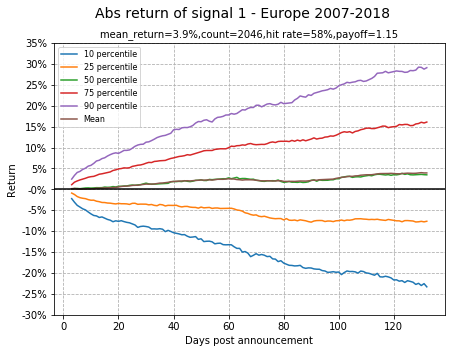

In [181]:
perf_chart_day(signal1_abs_df,"Days post announcement",
           "Return","Abs return of signal 1 - Europe 2007-2018",[7,5],
          [0.1,0.25,0.5,0.75,0.9])

## 5 - Account curve for long

Simulated performance of the portfolio by actual dates
- Basic plot
- By sectors
- By countries
- By size
- By PE
- By PE premium
- By holding period
- By entry point
- Stop loss
- Drawdown
- Moving average
- High price
- **Signal combination**
- Correlation with markets
- Performance for the following results

### 5.1 - Basic plot

In [97]:
# singal1 dataframe by actual date Europe
signal1_rel_df_date_Europe=signal1_df_date(data_dict_Europe['Date'],rel_return_Europe,rel_return_Europe,2,1000,data_dict_Europe['Revision'],0.02,1000,120,False,False,2)
signal1_abs_df_date_Europe=signal1_df_date(data_dict_Europe['Date'],rel_return_Europe,abs_return_Europe,2,1000,data_dict_Europe['Revision'],0.02,1000,120,False,False,2)

In [98]:
# singal1 dataframe by actual date US
signal1_rel_df_date_US=signal1_df_date(data_dict_US['Date'],rel_return_US,rel_return_US,2,1000,data_dict_US['Revision'],0.05,1000,120,False,False,2)
signal1_abs_df_date_US=signal1_df_date(data_dict_US['Date'],rel_return_US,abs_return_US,2,1000,data_dict_US['Revision'],0.05,1000,120,False,False,2)

In [143]:
# concatnate two dataframes to a global version
signal1_rel_df_date_global=pd.concat([signal1_rel_df_date_Europe,signal1_rel_df_date_US],axis=1)
signal1_abs_df_date_global=pd.concat([signal1_abs_df_date_Europe,signal1_abs_df_date_US],axis=1)

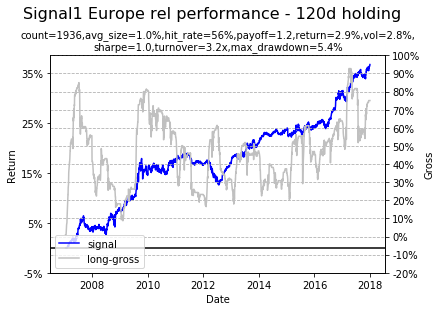

In [101]:
plot_account_curve(signal1_account(signal1_rel_df_date_Europe,50,100,volume,data_dict_Europe["Date"],0.1),
                   "Date","Signal1 Europe rel performance - 120d holding",[6,4])

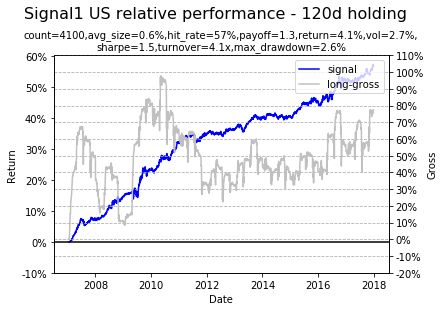

In [102]:
plot_account_curve(signal1_account(signal1_rel_df_date_US,50,100,data_dict_US["Volume"],data_dict_US["Date"],0.1),
                   "Date","Signal1 US relative performance - 120d holding",[6,4])

### 5.1 - Account curve by sectors

In [357]:
plot_account_curve_by_sector(data_dict_Europe["Property"]["Sector"],(13,80),18,
                            "Signal1 Account Curve by sectors - 120d holding",signal1_rel_df_date,
                            50,5,volume,data_dict_Europe["Date"],0.1)

### 5.2 - Account curve by countries

In [356]:
plot_account_curve_by_country((15,70),18,
                            "Performance of signal 1 for Europe 2007-2018",signal1_rel_df_date,
                            50,10,volume,data_dict_Europe["Date"],0.1)

### 5.3 - Account curve by size

In [353]:
plot_account_curve_by_size([0,0.25,0.5,0.75,1],(6,18),18,
                            "Account curve of signal 1 by size groups",signal1_rel_df_date,
                            50,30,volume,data_dict_Europe["Date"],market_cap,0.1)

### 5.4 - Account curve by PE

In [359]:
plot_account_curve_by_PE([0,0.17,0.34,0.5,0.67,0.84,1],(6,35),18,
                            "Account curve of signal 1 by PE groups",signal1_rel_df_date,
                            50,20,volume,data_dict_Europe["Date"],PE,0.1)

### 5.5 - Account curve by PE premium

In [ ]:
plot_account_curve_by_PE_premium([0,0.17,0.34,0.5,0.67,0.84,1],(6,35),18,
                            "Account curve of signal 1 by PE groups",signal1_rel_df_date,
                            50,20,volume,data_dict["Date"],PE_premium,0.1)

### 5.6 - Account curve by different holding periods

In [366]:
plot_account_curve(signal1_account(signal1_df_date(data_dict_Europe['Date'],rel_return_Europe,rel_return_Europe,2,100,data_dict_Europe['Revision'],0.02,1000,30,False,False,2)
                                   ,50,100,volume,data_dict_Europe["Date"],0.1),
                                   "Date","Signal1 account curve - 30d holding",[6,4])

plot_account_curve(signal1_account(signal1_df_date(data_dict_Europe['Date'],rel_return_Europe,rel_return_Europe,2,100,data_dict_Europe['Revision'],0.02,1000,60,False,False,2)
                                   ,50,100,volume,data_dict_Europe["Date"],0.1),
                                   "Date","Signal1 account curve - 60d holding",[6,4])

plot_account_curve(signal1_account(signal1_df_date(data_dict_Europe['Date'],rel_return_Europe,rel_return_Europe,2,100,data_dict_Europe['Revision'],0.02,1000,120,False,False,2)
                                   ,50,100,volume,data_dict_Europe["Date"],0.1),
                                   "Date","Signal1 account curve - 120d holding",[6,4])

plot_account_curve(signal1_account(signal1_df_date(data_dict_Europe['Date'],rel_return_Europe,rel_return_Europe,2,100,data_dict_Europe['Revision'],0.02,1000,240,False,False,2)
                                   ,50,100,volume,data_dict_Europe["Date"],0.1),
                                   "Date","Signal1 account curve - 240d holding",[6,4])

SyntaxError: invalid syntax (<ipython-input-366-e89e33a265a7>, line 1)

### 5.7 - Account curve by entry point

In [367]:
plot_account_curve(signal1_account(signal1_df_date(data_dict_Europe['Date'],rel_return_Europe,rel_return_Europe,2,100,data_dict_Europe['Revision'],0.02,1000,120,False,False,2)
                                   ,50,100,volume,data_dict_Europe["Date"],0.1),
                   "Date","Signal1 account curve from day2 - 120d holding",[6,4])

plot_account_curve(signal1_account(signal1_df_date(data_dict_Europe['Date'],rel_return_Europe,rel_return_Europe,2,100,data_dict_Europe['Revision'],0.02,1000,120,False,False,3)
                                   ,50,100,volume,data_dict_Europe["Date"],0.1),
                   "Date","Signal1 account curve from day3 - 120d holding",[6,4])

plot_account_curve(signal1_account(signal1_df_date(data_dict_Europe['Date'],rel_return_Europe,rel_return_Europe,2,100,data_dict_Europe['Revision'],0.02,1000,120,False,False,5)
                                   ,50,100,volume,data_dict_Europe["Date"],0.1),
                   "Date","Signal1 account curve from day5 - 120d holding",[6,4])

plot_account_curve(signal1_account(signal1_df_date(data_dict_Europe['Date'],rel_return_Europe,rel_return_Europe,2,100,data_dict_Europe['Revision'],0.02,1000,120,False,False,10)
                                   ,50,100,volume,data_dict_Europe["Date"],0.1),
                   "Date","Signal1 account curve from day10 - 120d holding",[6,4])

SyntaxError: EOF while scanning triple-quoted string literal (<ipython-input-367-6f27deb1e0dd>, line 15)

### 5.8 - Account curve with stop loss

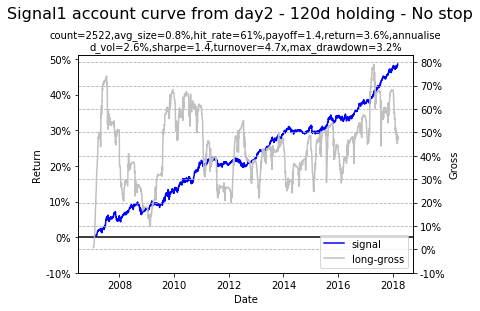

In [877]:
plot_account_curve(signal1_account(signal1_rel_df_date
                                   ,50,100,volume,data_dict_Europe["Date"],0.1),
                   "Date","Signal1 account curve from day2 - 120d holding - No stop",[6,4])

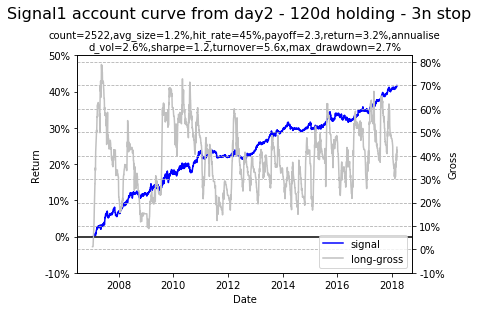

In [878]:
plot_account_curve(signal1_account(signal1_filter_stop(signal1_rel_df_date,3,rel_return_Europe,30)
                                   ,50,100,volume,data_dict_Europe["Date"],0.1),
                   "Date","Signal1 account curve from day2 - 120d holding - 3n stop",[6,4])

### 5.9 - Account curve with drawdown stop

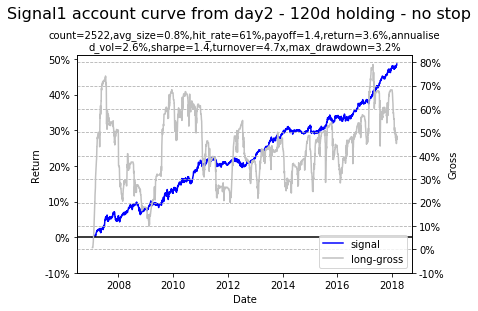

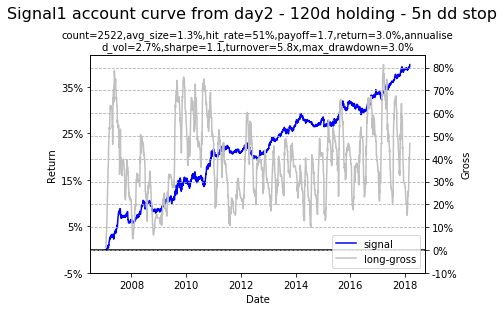

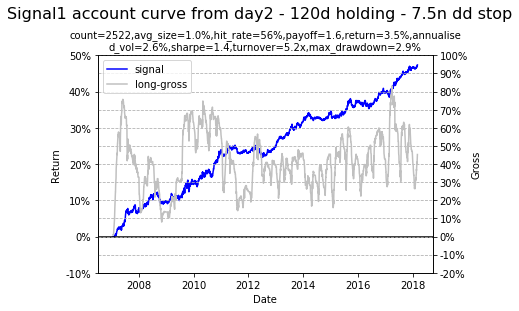

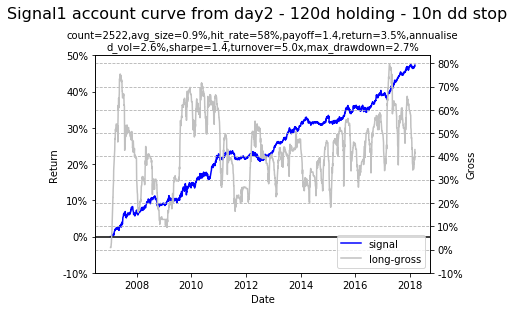

In [881]:
plot_account_curve(signal1_account(signal1_rel_df_date,50,100,volume,data_dict_Europe["Date"],0.1),
                   "Date","Signal1 account curve from day2 - 120d holding - no stop",[6,4])

plot_account_curve(signal1_account(signal1_filter_dd(signal1_rel_df_date,5,rel_return_Europe,30)
                                   ,50,100,volume,data_dict_Europe["Date"],0.1),
                   "Date","Signal1 account curve from day2 - 120d holding - 5n dd stop",[6,4])

plot_account_curve(signal1_account(signal1_filter_dd(signal1_rel_df_date,7.5,rel_return_Europe,30)
                                   ,50,100,volume,data_dict_Europe["Date"],0.1),
                   "Date","Signal1 account curve from day2 - 120d holding - 7.5n dd stop",[6,4])

plot_account_curve(signal1_account(signal1_filter_dd(signal1_rel_df_date,10,rel_return_Europe,30)
                                   ,50,100,volume,data_dict_Europe["Date"],0.1),
                   "Date","Signal1 account curve from day2 - 120d holding - 10n dd stop",[6,4])

### 5.10 - Account curve with moving average

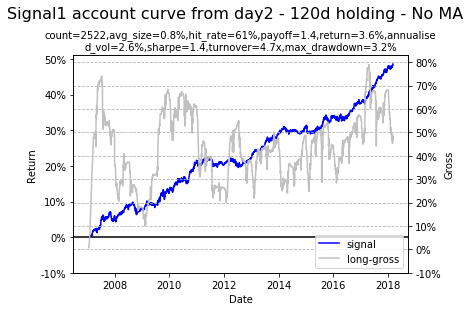

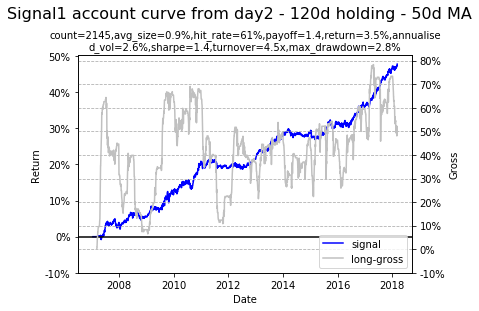

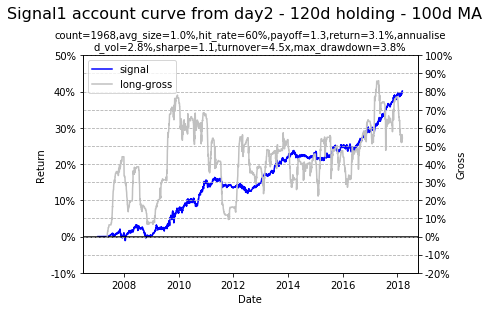

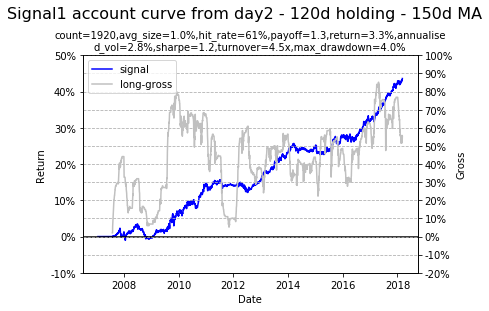

In [883]:
plot_account_curve(signal1_account(signal1_rel_df_date,50,100,volume,data_dict_Europe["Date"],0.1),
                   "Date","Signal1 account curve from day2 - 120d holding - No MA",[6,4])

plot_account_curve(signal1_account(signal1_filter_MA(signal1_rel_df_date,price_Europe,50)
                                   ,50,100,volume,data_dict_Europe["Date"],0.1),
                   "Date","Signal1 account curve from day2 - 120d holding - 50d MA",[6,4])

plot_account_curve(signal1_account(signal1_filter_MA(signal1_rel_df_date,price_Europe,100)
                                   ,50,100,volume,data_dict_Europe["Date"],0.1),
                   "Date","Signal1 account curve from day2 - 120d holding - 100d MA",[6,4])

plot_account_curve(signal1_account(signal1_filter_MA(signal1_rel_df_date,price_Europe,150)
                                   ,50,100,volume,data_dict_Europe["Date"],0.1),
                   "Date","Signal1 account curve from day2 - 120d holding - 150d MA",[6,4])

### 5.11 - Account curve with abs/rel high

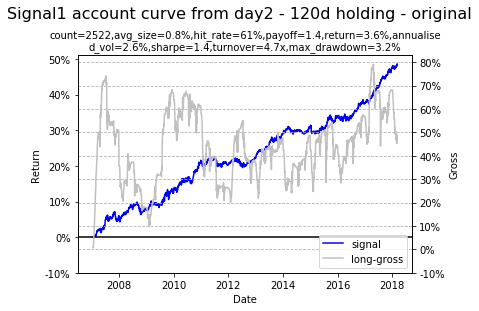

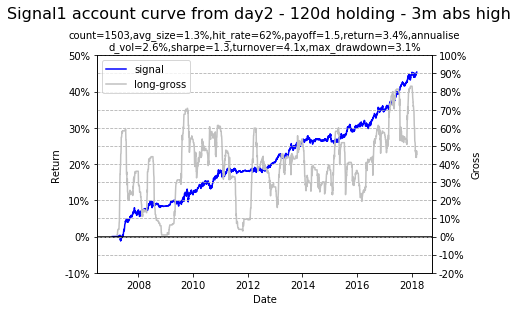

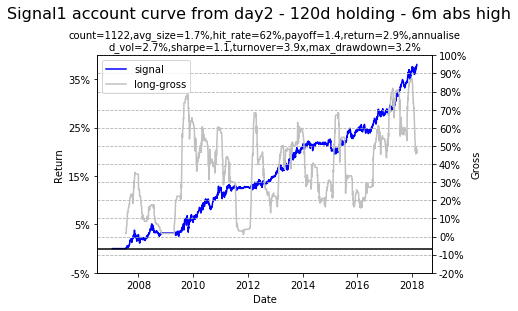

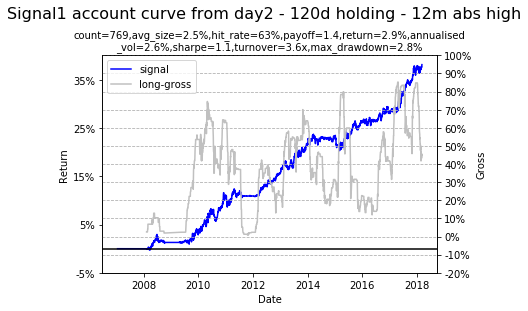

In [884]:
plot_account_curve(signal1_account(signal1_rel_df_date,50,100,volume,data_dict_Europe["Date"],0.1),
                   "Date","Signal1 account curve from day2 - 120d holding - original",[6,4])

plot_account_curve(signal1_account(signal1_filter_high(signal1_rel_df_date,price_Europe,60)
                                   ,50,100,volume,data_dict_Europe["Date"],0.1),
                   "Date","Signal1 account curve from day2 - 120d holding - 3m abs high",[6,4])

plot_account_curve(signal1_account(signal1_filter_high(signal1_rel_df_date,price_Europe,120)
                                   ,50,100,volume,data_dict_Europe["Date"],0.1),
                   "Date","Signal1 account curve from day2 - 120d holding - 6m abs high",[6,4])

plot_account_curve(signal1_account(signal1_filter_high(signal1_rel_df_date,price_Europe,240)
                                   ,50,100,volume,data_dict_Europe["Date"],0.1),
                   "Date","Signal1 account curve from day2 - 120d holding - 12m abs high",[6,4])

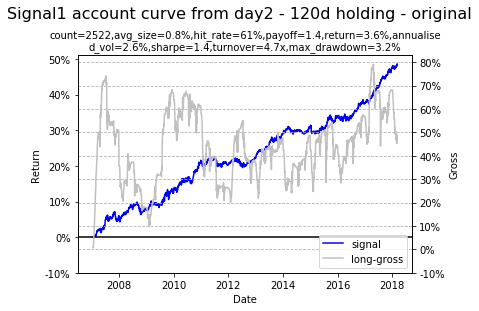

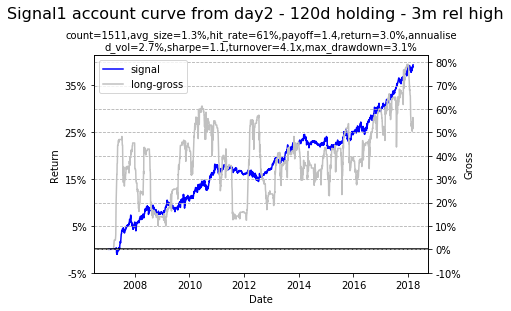

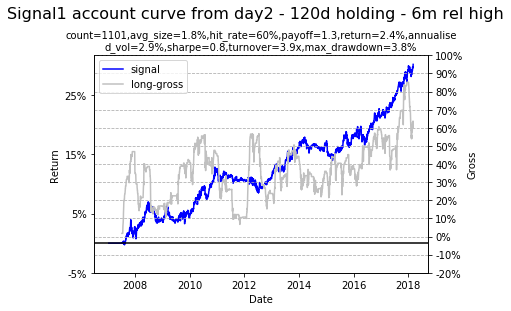

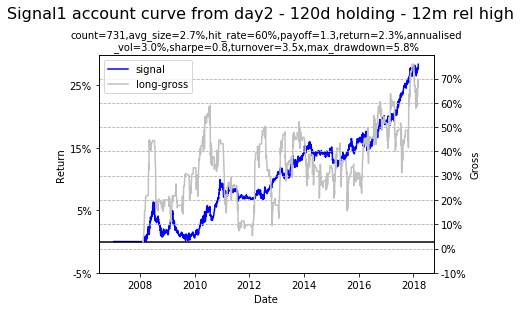

In [885]:
plot_account_curve(signal1_account(signal1_rel_df_date,50,100,volume,data_dict_Europe["Date"],0.1),
                   "Date","Signal1 account curve from day2 - 120d holding - original",[6,4])

plot_account_curve(signal1_account(signal1_filter_high(signal1_rel_df_date,rel_price_Europe,60)
                                   ,50,100,volume,data_dict_Europe["Date"],0.1),
                   "Date","Signal1 account curve from day2 - 120d holding - 3m rel high",[6,4])

plot_account_curve(signal1_account(signal1_filter_high(signal1_rel_df_date,rel_price_Europe,120)
                                   ,50,100,volume,data_dict_Europe["Date"],0.1),
                   "Date","Signal1 account curve from day2 - 120d holding - 6m rel high",[6,4])

plot_account_curve(signal1_account(signal1_filter_high(signal1_rel_df_date,rel_price_Europe,240)
                                   ,50,100,volume,data_dict_Europe["Date"],0.1),
                   "Date","Signal1 account curve from day2 - 120d holding - 12m rel high",[6,4])

### 5.12 - Stress test the base case by altering earning upgrade and price move up
** BE CAREFUL WITH THIS!!! **

In [726]:
# get the revision and EAR quantile
revision_list=data_dict_Europe['Revision'].unstack(level=-1).dropna()
revision_quantile=revision_list.quantile([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]).tolist()
EAR_full=EAR_df(data_dict_Europe["Date"],rel_return_Europe,2,30).fillna(0.0).reindex(data_dict_Europe['Revision'].index.tolist())
EAR_list=EAR_full.unstack(level=-1)[EAR_full.unstack(level=-1)!=0]
EAR_quantile=EAR_list.quantile([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]).tolist()

In [730]:
# build the monster dictionary of different scenarios of base signal, this is gonna take an hour!!!!!!!!!!!!!
EAR_upgrade_dict={}

for idx in range(len(EAR_quantile)-1):
    for i in range(len(revision_quantile)-1):
        EAR_upgrade_dict[("Move "+str(round(EAR_quantile[idx],1))+str(" to ")+str(round(EAR_quantile[idx+1],1)),
                          "Upgrade "+str("{:.1%}".format(revision_quantile[i]))+str(" to ")+str("{:.1%}".format(revision_quantile[i+1])))]=trading_analytics_date(signal1_account(
                                    signal1_df_date(data_dict_Europe['Date'],rel_return_Europe,rel_return_Europe,EAR_quantile[idx],EAR_quantile[idx+1],data_dict['Revision'],revision_quantile[i],revision_quantile[i+1],120,True,True,2)
                                   ,50,100,volume,data_dict_Europe["Date"],0.1))

In [735]:
# Build a dummy dataframe with the relevant column and index names
EAR_upgrade_df=pd.DataFrame(np.zeros((10,10)),
                  columns=["Upgrade "+str("{:.1%}".format(revision_quantile[i]))+str(" to ")+str("{:.1%}".format(revision_quantile[i+1])) for i in range(len(revision_quantile)-1)],
                  index=["Move "+str(round(EAR_quantile[i],1))+str(" to ")+str(round(EAR_quantile[i+1],1)) for i in range(len(EAR_quantile)-1)])

In [770]:
# fill in relevant sharpe data
EAR_upgrade_sharpe=EAR_upgrade_df.copy()
for i,ival in enumerate(EAR_upgrade_sharpe.index.tolist()):
    for j,jval in enumerate(EAR_upgrade_sharpe.columns.tolist()):
        EAR_upgrade_sharpe.iloc[i,j]=round(EAR_upgrade_dict[(ival,jval)][5],2)

In [788]:
# fill in relevant return data
EAR_upgrade_ret=EAR_upgrade_df.copy()
for i,ival in enumerate(EAR_upgrade_ret.index.tolist()):
    for j,jval in enumerate(EAR_upgrade_ret.columns.tolist()):
        EAR_upgrade_ret.iloc[i,j]=round(EAR_upgrade_dict[(ival,jval)][3],3)

### 5.13 -  Market correlation

In [155]:
# Signal account curve
account_rel_Europe=signal1_account(signal1_rel_df_date_Europe,50,100,volume,data_dict_Europe["Date"],0.1)[0]
account_rel_Europe.name="Signal1 Europe rel"
account_abs_Europe=signal1_account(signal1_abs_df_date_Europe,100,100,volume,data_dict_Europe["Date"],0.1)[0]
account_abs_Europe.name="Signal1 Europe abs"
account_rel_US=signal1_account(signal1_rel_df_date_US,50,100,volume_US,data_dict_US["Date"],0.1)[0]
account_rel_US.name="Signal1 US rel"
account_abs_US=signal1_account(signal1_abs_df_date_US,100,100,volume_US,data_dict_US["Date"],0.1)[0]
account_abs_US.name="Signal1 US abs"
account_rel_global=signal1_account(signal1_rel_df_date_global,50,100,data_dict_global["Volume"],data_dict_global["Date"],0.1)[0]
account_rel_global.name="Signal1 US+Europe rel"
account_abs_global=signal1_account(signal1_rel_df_date_global,100,100,data_dict_global["Volume"],data_dict_global["Date"],0.1)[0]
account_abs_global.name="Signal1 US+Europe abs"

In [156]:
account_df=pd.concat([account_rel_Europe,account_abs_Europe,account_rel_US,account_abs_US,
                     account_rel_global,account_abs_global],axis=1)

In [157]:
# Market
account_SXXP=(1+abs_return_Europe.loc["SXXP Index"]).cumprod()-1
account_momentum_Europe=(1+abs_return_Europe.loc["GSRPEMEL Index"]).cumprod()-1
account_momentum_US=(1+abs_return_US.loc["GSRPEMUL Index"]).cumprod()-1
account_SPX=(1+abs_return_US.loc["SPX Index"]).cumprod()-1
index_df=pd.concat([account_SXXP,account_momentum_Europe,account_momentum_US,account_SPX],axis=1)
index_df=index_df.reindex([datetime.strptime(x,"%d/%b/%Y") for x in index_df.index]).sort_index()

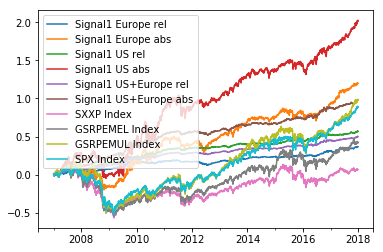

In [158]:
# Add them together and plot
account_combined=pd.concat([account_df,index_df],axis=1)
account_combined.plot()

In [159]:
# Correlation matrix
account_combined.corr()

Signal1 Europe rel  Signal1 Europe abs  Signal1 US rel  \
Signal1 Europe rel               1.000000            0.942117        0.966523   
Signal1 Europe abs               0.942117            1.000000        0.939763   
Signal1 US rel                   0.966523            0.939763        1.000000   
Signal1 US abs                   0.942105            0.989204        0.966108   
Signal1 US+Europe rel            0.981844            0.946971        0.997635   
Signal1 US+Europe abs            0.981505            0.945892        0.997744   
SXXP Index                       0.387995            0.621761        0.338346   
GSRPEMEL Index                   0.616179            0.803826        0.583306   
GSRPEMUL Index                   0.741499            0.885761        0.715978   
SPX Index                        0.783453            0.908748        0.752799   

                       Signal1 US abs  Signal1 US+Europe rel  \
Signal1 Europe rel           0.942105               0.981844   
Signal1 Europe abs           0.989204               0.946971   
Signal1 US rel               0.966108               0.997635   
Signal1 US abs               1.000000               0.966362   
Signal1 US+Europe rel        0.966362               1.000000   
Signal1 US+Europe abs        0.965560               0.999985   
SXXP Index                   0.547972               0.355278   
GSRPEMEL Index               0.753980               0.597216   
GSRPEMUL Index               0.858113               0.728458   
SPX Index                    0.879821               0.767013   

                       Signal1 US+Europe abs  SXXP Index  GSRPEMEL Index  \
Signal1 Europe rel                  0.981505    0.387995        0.616179   
Signal1 Europe abs                  0.945892    0.621761        0.803826   
Signal1 US rel                      0.997744    0.338346        0.583306   
Signal1 US abs                      0.965560    0.547972        0.753980   
Signal1 US+Europe rel               0.999985    0.355278        0.597216   
Signal1 US+Europe abs               1.000000    0.351636        0.593859   
SXXP Index                          0.351636    1.000000        0.946136   
GSRPEMEL Index                      0.593859    0.946136        1.000000   
GSRPEMUL Index                      0.725399    0.853733        0.969108   
SPX Index                           0.764129    0.835293        0.959373   

                       GSRPEMUL Index  SPX Index  
Signal1 Europe rel           0.741499   0.783453  
Signal1 Europe abs           0.885761   0.908748  
Signal1 US rel               0.715978   0.752799  
Signal1 US abs               0.858113   0.879821  
Signal1 US+Europe rel        0.728458   0.767013  
Signal1 US+Europe abs        0.725399   0.764129  
SXXP Index                   0.853733   0.835293  
GSRPEMEL Index               0.969108   0.959373  
GSRPEMUL Index               1.000000   0.993442  
SPX Index                    0.993442   1.000000

### 5.14 - Performance over subsequent quarters

In [658]:
signal1_follow_US=signal1_follow(signal1_US,data_dict_US["Date"],10)
signal1_follow=signal1_follow(signal1,data_dict_Europe["Date"],10)

In [660]:
follow_US=signal1_follow_EAR(signal1_follow_US,abs_return_US,2,30)
follow=signal1_follow_EAR(signal1_follow,abs_return_Europe,2,30)

C:\Users\Eric.Li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]


In [661]:
follow_US=follow_US.sort_values(by='Quarter+0',axis=1)
follow=follow.sort_values(by='Quarter+0',axis=1)

## 6 - Average return trajectory for short

In [189]:
# obtain the short signals
signal1_short_Europe,signal1_short_next_Europe=signal1_formation(data_dict_Europe['Date'],rel_return_Europe,2,-1000,-2,data_dict_Europe['Revision'],-1000,-0.02)
signal1_short_US,signal1_short_next_US=signal1_formation(data_dict_US['Date'],rel_return_US,2,-1000,-2,data_dict_US['Revision'],-1000,-0.05)

In [ ]:
# Short signal dataframe
signal1_short_abs_df_Europe=signal1_df_day(signal1_short_Europe,signal1_short_Europe_next,abs_return_Europe,120,True,2)
signal1_short_rel_df_Europe=signal1_df_day(signal1_short_Europe,signal1_short_Europe_next,rel_return_Europe,120,True,2)

signal1_short_abs_df_US=signal1_df_day(signal1_short_US,signal1_short_next_US,abs_return_US,120,True,2)
signal1_short_rel_df_US=signal1_df_day(signal1_short_US,signal1_short_next_US,rel_return_US,120,True,2)

In [376]:
# Europe signal list
signal1_short_list_rel_Europe=((1+signal1_short_rel_df_Europe).cumprod(axis=0)-1).ffill().iloc[-1]
signal1_short_list_rel_Europe.sort_values()

In [375]:
# US signal list
signal1_short_list_rel_US=((1+signal1_short_rel_df_US).cumprod(axis=0)-1).ffill().iloc[-1]
signal1_short_list_rel_US.sort_values()

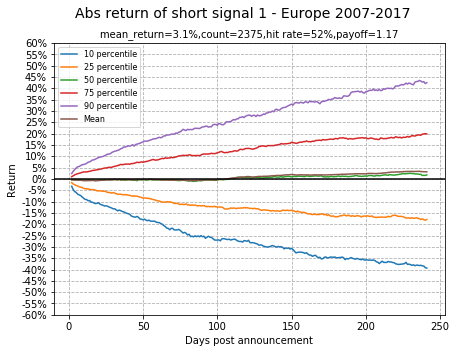

In [184]:
perf_chart_day(signal1_df_day(signal1_short_Europe,signal1_short_next_Europe,abs_return_Europe,240,True,2)
               ,"Days post announcement","Return","Abs return of short signal 1 - Europe 2007-2017",[7,5],
               [0.1,0.25,0.5,0.75,0.9])

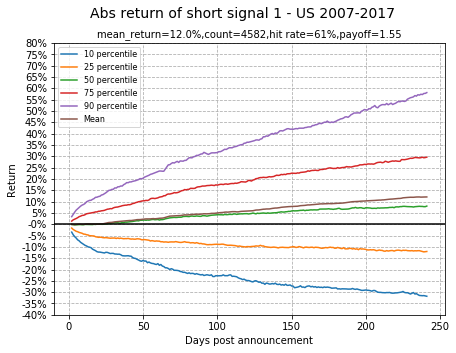

In [187]:
perf_chart_day(signal1_df_day(signal1_short_US,signal1_short_next_US,abs_return_US,240,True,2)
               ,"Days post announcement","Return","Abs return of short signal 1 - US 2007-2017",[7,5],
               [0.1,0.25,0.5,0.75,0.9])

## 7 - Account curve for short

Simulated performance of the portfolio by actual dates
- Basic plot by holding period and next result
- By entry point
- By size
- By PE and PE premium
- By sectors
- Stop loss
- Performance for the following results

### 7.1 - Basic plot by holding period and next result

In [319]:
# singal1 short dataframe by actual date US
signal1_rel_df_date_short_US=signal1_df_date(data_dict_US['Date'],rel_return_US,rel_return_US,-1000,-2,data_dict_US['Revision'],-1000,-0.02,90,False,False,2)
signal1_abs_df_date_short_US=signal1_df_date(data_dict_US['Date'],rel_return_US,abs_return_US,-1000,-2,data_dict_US['Revision'],-1000,-0.02,90,False,False,2)

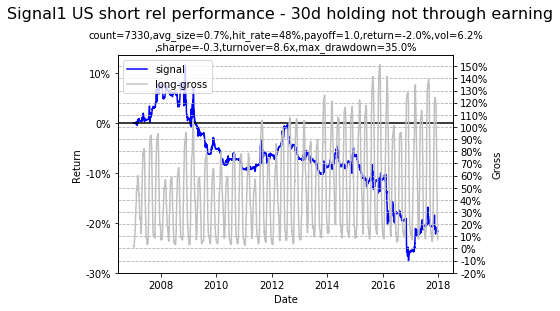

In [244]:
plot_account_curve(signal1_account(-signal1_df_date(data_dict_US['Date'],rel_return_US,rel_return_US,-1000,-2,data_dict_US['Revision'],-1000,-0.02,30,False,False,2)
                                   ,50,100,data_dict_US["Volume"],data_dict_US["Date"],0.1),
                   "Date","Signal1 US short rel performance - 30d holding not through earning",[6,4])

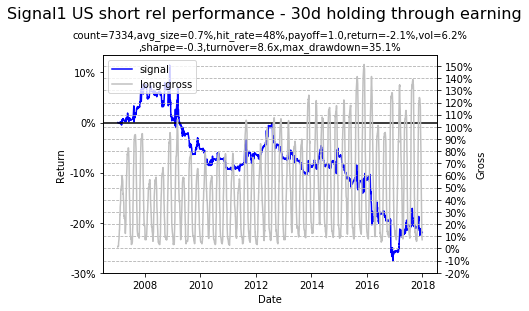

In [248]:
plot_account_curve(signal1_account(-signal1_df_date(data_dict_US['Date'],rel_return_US,rel_return_US,-1000,-2,data_dict_US['Revision'],-1000,-0.02,30,True,True,2)
                                   ,50,100,data_dict_US["Volume"],data_dict_US["Date"],0.1),
                   "Date","Signal1 US short rel performance - 30d holding through earning",[6,4])

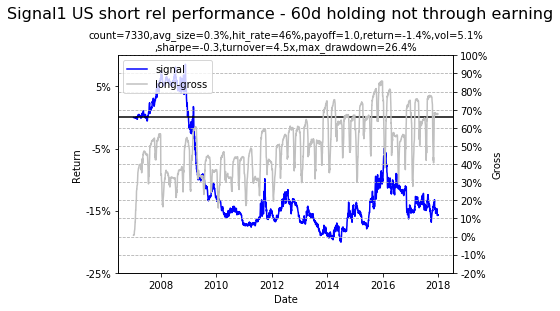

In [243]:
plot_account_curve(signal1_account(-signal1_df_date(data_dict_US['Date'],rel_return_US,rel_return_US,-1000,-2,data_dict_US['Revision'],-1000,-0.02,60,False,False,2)
                                   ,50,100,data_dict_US["Volume"],data_dict_US["Date"],0.1),
                   "Date","Signal1 US short rel performance - 60d holding not through earning",[6,4])

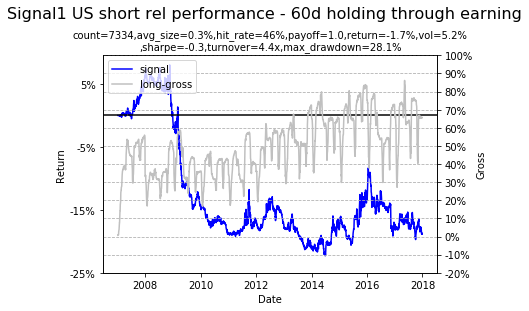

In [242]:
plot_account_curve(signal1_account(-signal1_df_date(data_dict_US['Date'],rel_return_US,rel_return_US,-1000,-2,data_dict_US['Revision'],-1000,-0.02,60,True,True,2)
                                   ,50,100,data_dict_US["Volume"],daata_dict_US["Date"],0.1),
                   "Date","Signal1 US short rel performance - 60d holding through earning",[6,4])

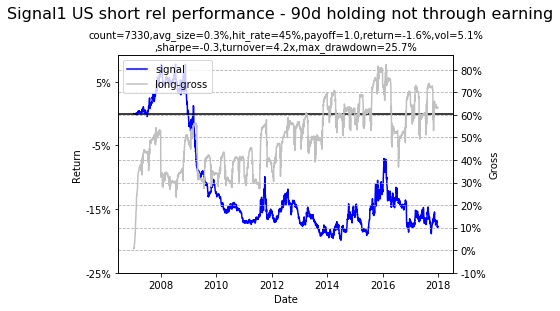

In [301]:
plot_account_curve(signal1_account(-signal1_df_date(data_dict_US['Date'],rel_return_US,rel_return_US,-1000,-2,data_dict_US['Revision'],-1000,-0.02,90,False,False,2)
                                   ,50,100,data_dict_US["Volume"],data_dict_US["Date"],0.1),
                   "Date","Signal1 US short rel performance - 90d holding not through earning",[6,4])

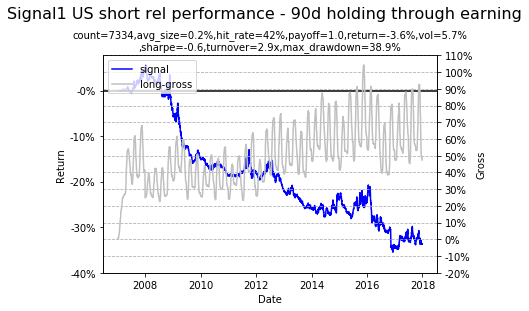

In [302]:
plot_account_curve(signal1_account(-signal1_df_date(data_dict_US['Date'],rel_return_US,rel_return_US,-1000,-2,data_dict_US['Revision'],-1000,-0.02,90,True,True,2)
                                   ,50,100,data_dict_US["Volume"],data_dict_US["Date"],0.1),
                   "Date","Signal1 US short rel performance - 90d holding through earning",[6,4])

In [ ]:
# singal1 short dataframe by actual date Europe
signal1_rel_df_date_short_Europe=signal1_df_date(data_dict_Europe['Date'],rel_return_Europe,rel_return_Europe,-1000,-2,data_dict_US['Revision'],-1000,-0.02,120,False,False,2)
signal1_abs_df_date_short_Europe=signal1_df_date(data_dict_Europe['Date'],rel_return_Europe,abs_return_Europe,-1000,-2,data_dict_US['Revision'],-1000,-0.02,120,False,False,2)

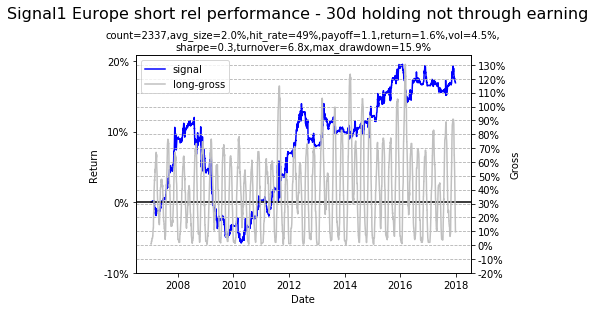

In [312]:
plot_account_curve(signal1_account(-signal1_df_date(data_dict_Europe['Date'],rel_return_Europe,rel_return_Europe,-1000,-2,data_dict_Europe['Revision'],-1000,-0.02,30,False,False,2)
                                   ,50,100,data_dict_Europe["Volume"],data_dict_Europe["Date"],0.1),
                   "Date","Signal1 Europe short rel performance - 30d holding not through earning",[6,4])

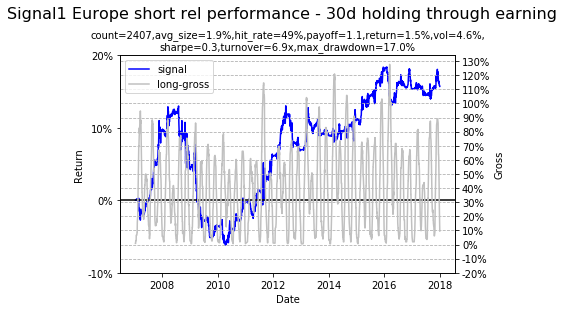

In [313]:
plot_account_curve(signal1_account(-signal1_df_date(data_dict_Europe['Date'],rel_return_Europe,rel_return_Europe,-1000,-2,data_dict_Europe['Revision'],-1000,-0.02,30,True,True,2)
                                   ,50,100,data_dict_Europe["Volume"],data_dict_Europe["Date"],0.1),
                   "Date","Signal1 Europe short rel performance - 30d holding through earning",[6,4])

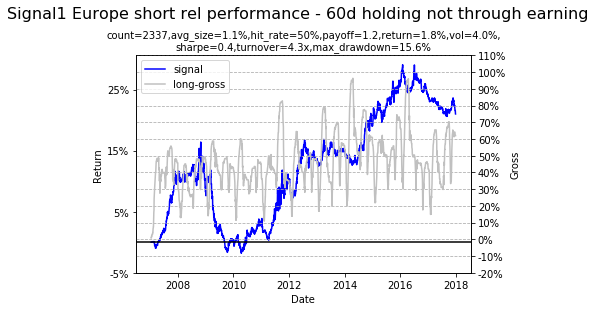

In [311]:
plot_account_curve(signal1_account(-signal1_df_date(data_dict_Europe['Date'],rel_return_Europe,rel_return_Europe,-1000,-2,data_dict_Europe['Revision'],-1000,-0.02,60,False,False,2)
                                   ,50,100,data_dict_Europe["Volume"],data_dict_Europe["Date"],0.1),
                   "Date","Signal1 Europe short rel performance - 60d holding not through earning",[6,4])

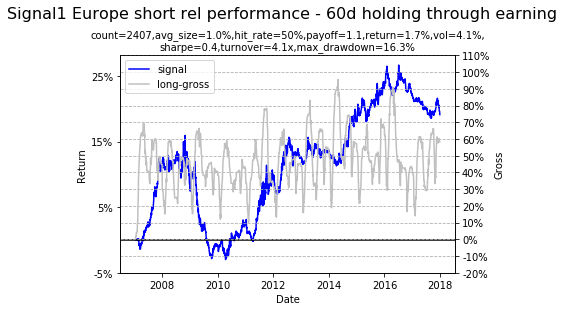

In [314]:
plot_account_curve(signal1_account(-signal1_df_date(data_dict_Europe['Date'],rel_return_Europe,rel_return_Europe,-1000,-2,data_dict_Europe['Revision'],-1000,-0.02,60,True,True,2)
                                   ,50,100,data_dict_Europe["Volume"],data_dict_Europe["Date"],0.1),
                   "Date","Signal1 Europe short rel performance - 60d holding through earning",[6,4])

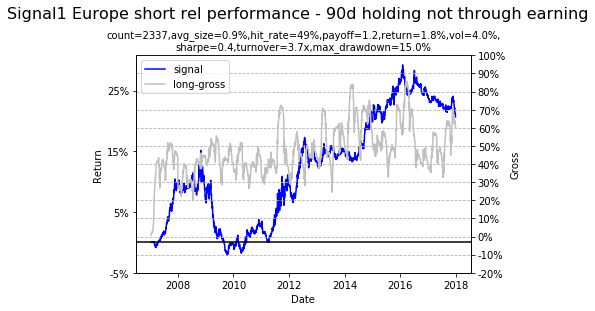

In [315]:
plot_account_curve(signal1_account(-signal1_df_date(data_dict_Europe['Date'],rel_return_Europe,rel_return_Europe,-1000,-2,data_dict_Europe['Revision'],-1000,-0.02,90,False,False,2)
                                   ,50,100,data_dict_Europe["Volume"],data_dict_Europe["Date"],0.1),
                   "Date","Signal1 Europe short rel performance - 90d holding not through earning",[6,4])

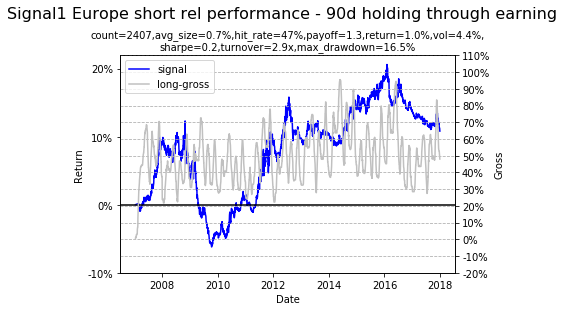

In [316]:
plot_account_curve(signal1_account(-signal1_df_date(data_dict_Europe['Date'],rel_return_Europe,rel_return_Europe,-1000,-2,data_dict_Europe['Revision'],-1000,-0.02,90,True,True,2)
                                   ,50,100,data_dict_Europe["Volume"],data_dict_Europe["Date"],0.1),
                   "Date","Signal1 Europe short rel performance - 90d holding through earning",[6,4])

### 7.2 - Short signal performance by entry point

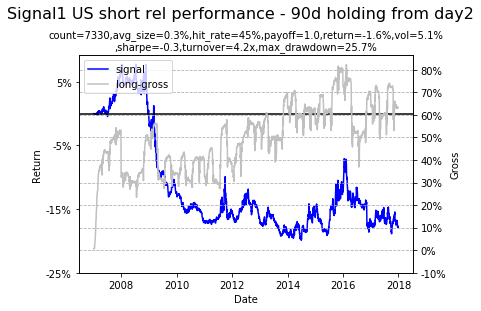

In [303]:
plot_account_curve(signal1_account(-signal1_df_date(data_dict_US['Date'],rel_return_US,rel_return_US,-1000,-2,data_dict_US['Revision'],-1000,-0.02,90,False,False,2)
                                   ,50,100,data_dict_US["Volume"],data_dict_US["Date"],0.1),
                   "Date","Signal1 US short rel performance - 90d holding from day2",[6,4])

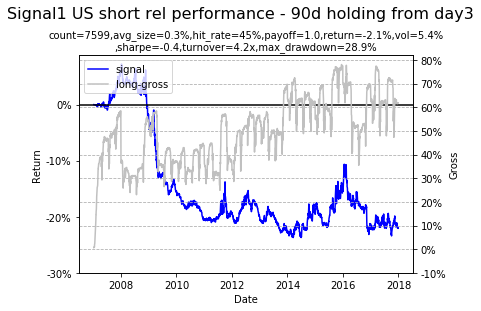

In [304]:
plot_account_curve(signal1_account(-signal1_df_date(data_dict_US['Date'],rel_return_US,rel_return_US,-1000,-2,data_dict_US['Revision'],-1000,-0.02,90,False,False,3)
                                   ,50,100,data_dict_US["Volume"],data_dict_US["Date"],0.1),
                   "Date","Signal1 US short rel performance - 90d holding from day3",[6,4])

### 7.3 - Short account curve by size

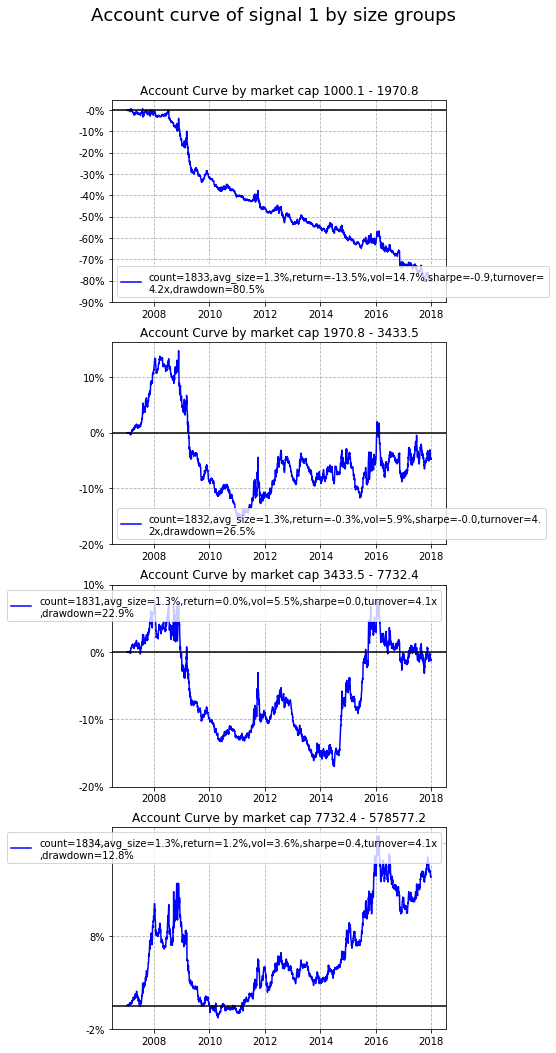

In [267]:
plot_account_curve_by_size([0,0.25,0.5,0.75,1],(6,26),18,
                            "Account curve of signal 1 by size groups",-signal1_rel_df_date_short_US,
                            50,30,data_dict_US["Volume"],data_dict_US["Date"],data_dict_US["Market cap"],0.1)

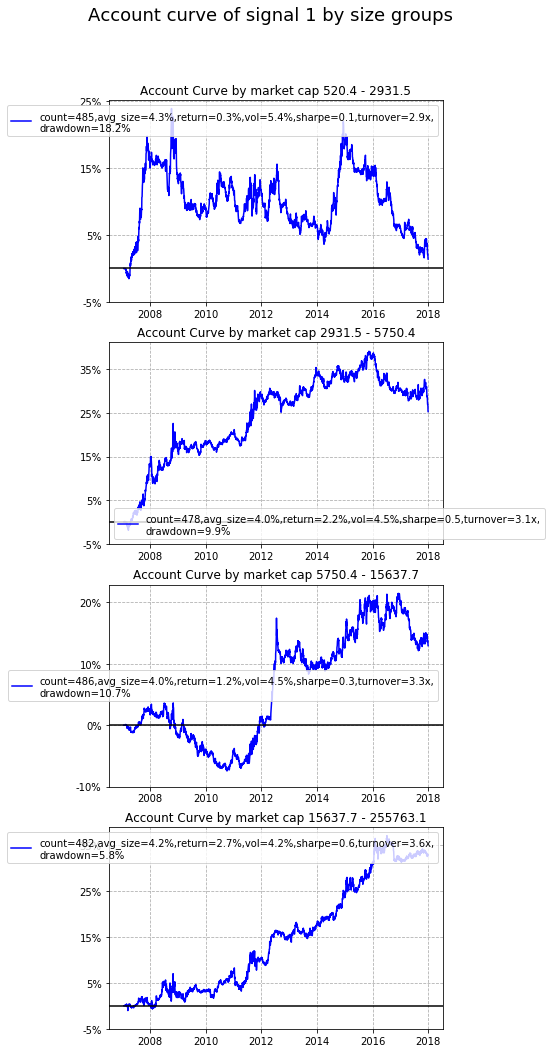

In [320]:
plot_account_curve_by_size([0,0.25,0.5,0.75,1],(6,26),18,
                            "Account curve of signal 1 by size groups",-signal1_rel_df_date_short_Europe,
                            50,30,data_dict_Europe["Volume"],data_dict_Europe["Date"],data_dict_Europe["Market cap"],0.1)

### 7.4 - Short signal performance by PE

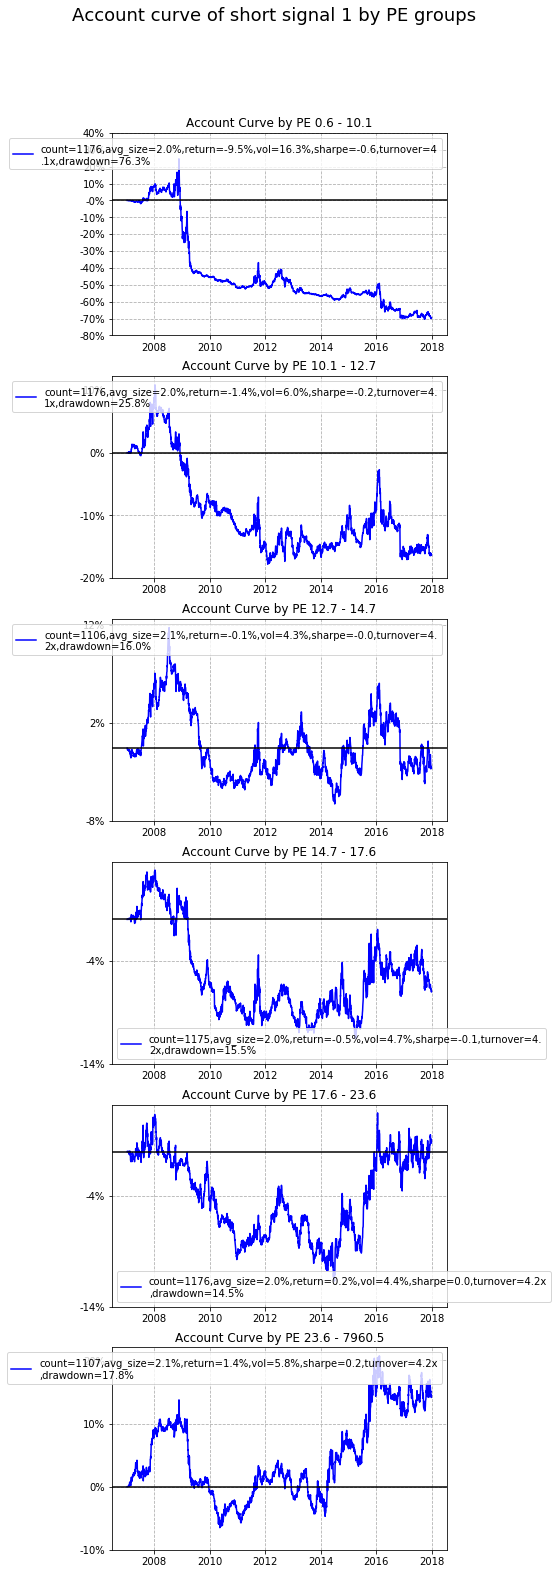

In [276]:
plot_account_curve_by_PE([0,0.17,0.34,0.5,0.67,0.84,1],(6,35),18,
                            "Account curve of short signal 1 by PE groups",-signal1_rel_df_date_short_US,
                            50,20,data_dict_US["Volume"],data_dict_US["Date"],data_dict_US["PE"],0.1)

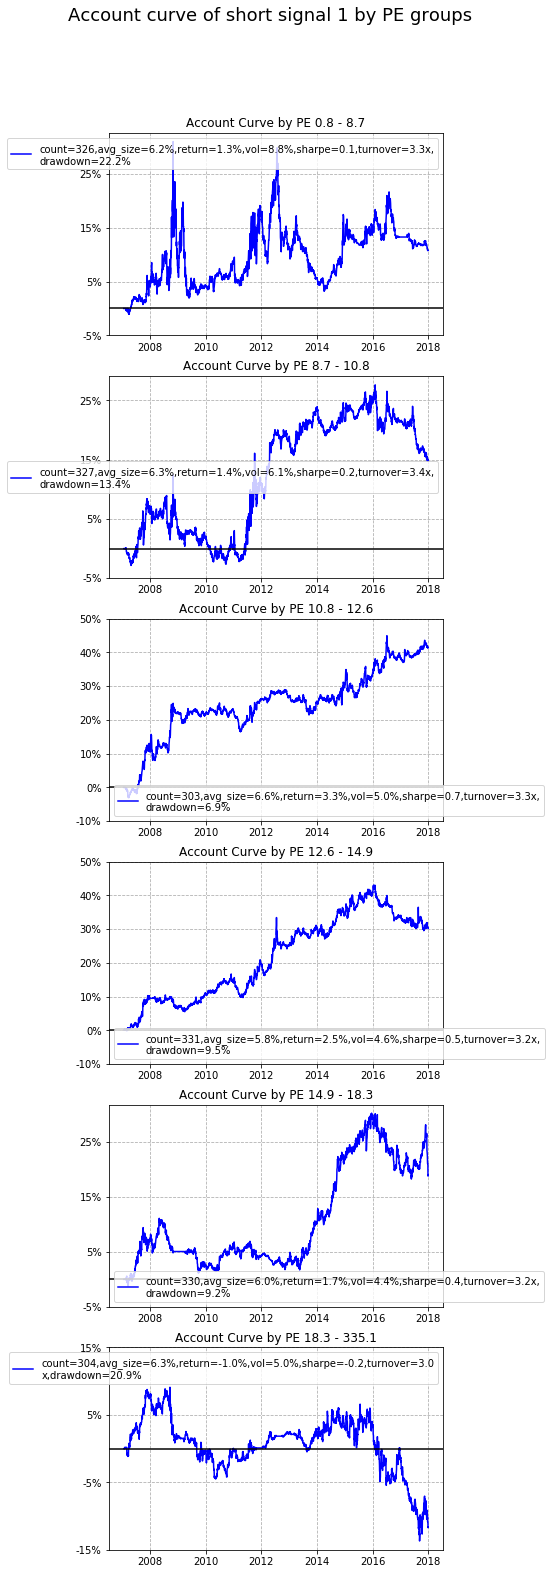

In [321]:
plot_account_curve_by_PE([0,0.17,0.34,0.5,0.67,0.84,1],(6,35),18,
                            "Account curve of short signal 1 by PE groups",-signal1_rel_df_date_short_Europe,
                            50,20,data_dict_Europe["Volume"],data_dict_Europe["Date"],data_dict_Europe["PE"],0.1)

### 7.5 - Short signal performance by PE premium

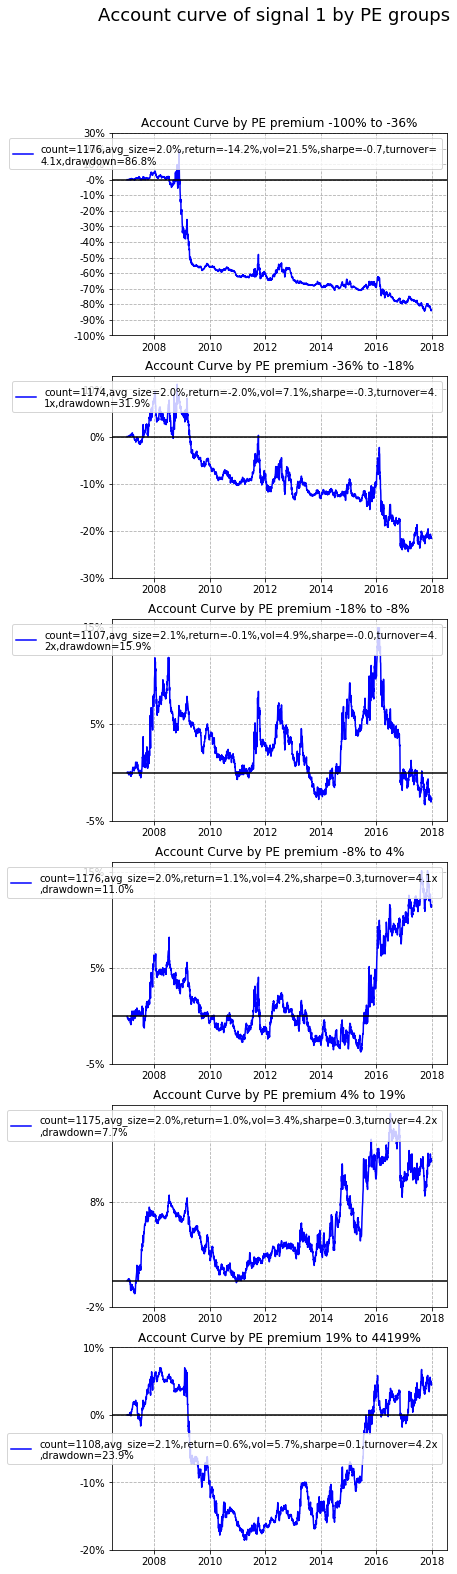

In [280]:
plot_account_curve_by_PE_premium([0,0.17,0.34,0.5,0.67,0.84,1],(6,35),18,
                            "Account curve of signal 1 by PE groups",-signal1_rel_df_date_short_US,
                            50,20,data_dict_US["Volume"],data_dict_US["Date"],data_dict_US["PE premium"],0.1)

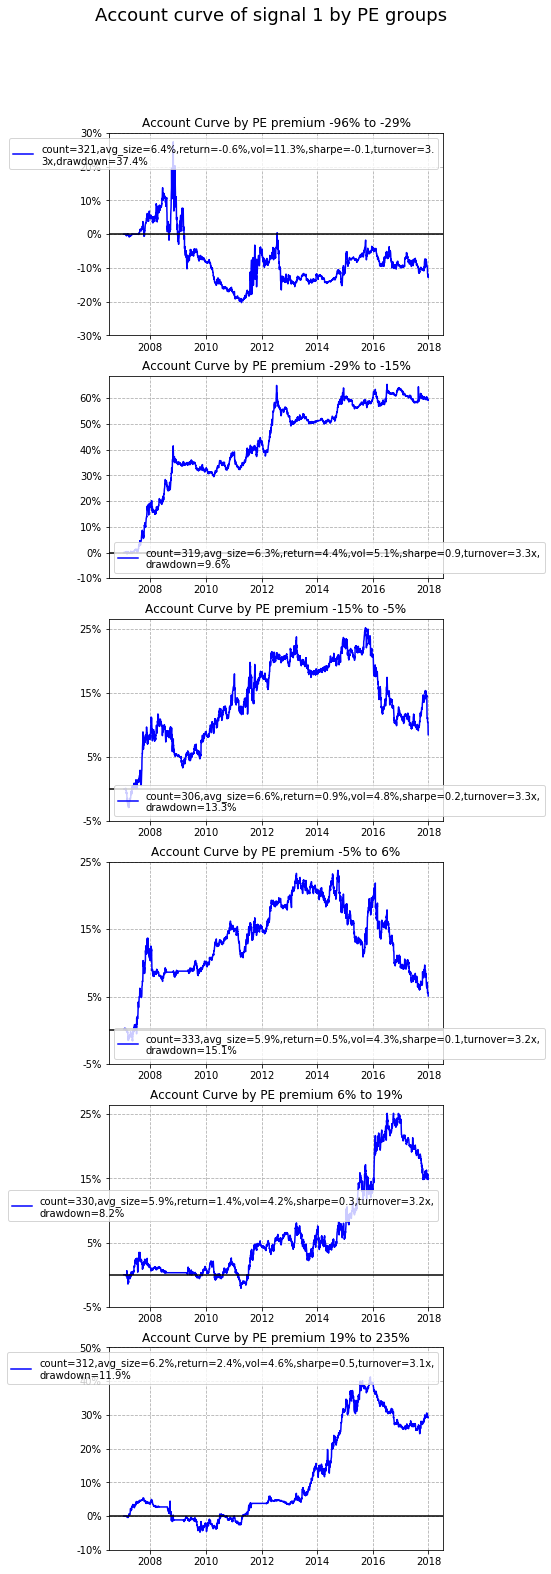

In [323]:
plot_account_curve_by_PE_premium([0,0.17,0.34,0.5,0.67,0.84,1],(6,35),18,
                            "Account curve of signal 1 by PE groups",-signal1_rel_df_date_short_Europe,
                            50,20,data_dict_Europe["Volume"],data_dict_Europe["Date"],data_dict_Europe["PE premium"],0.1)

### 7.6 - Short signal performance by sectors

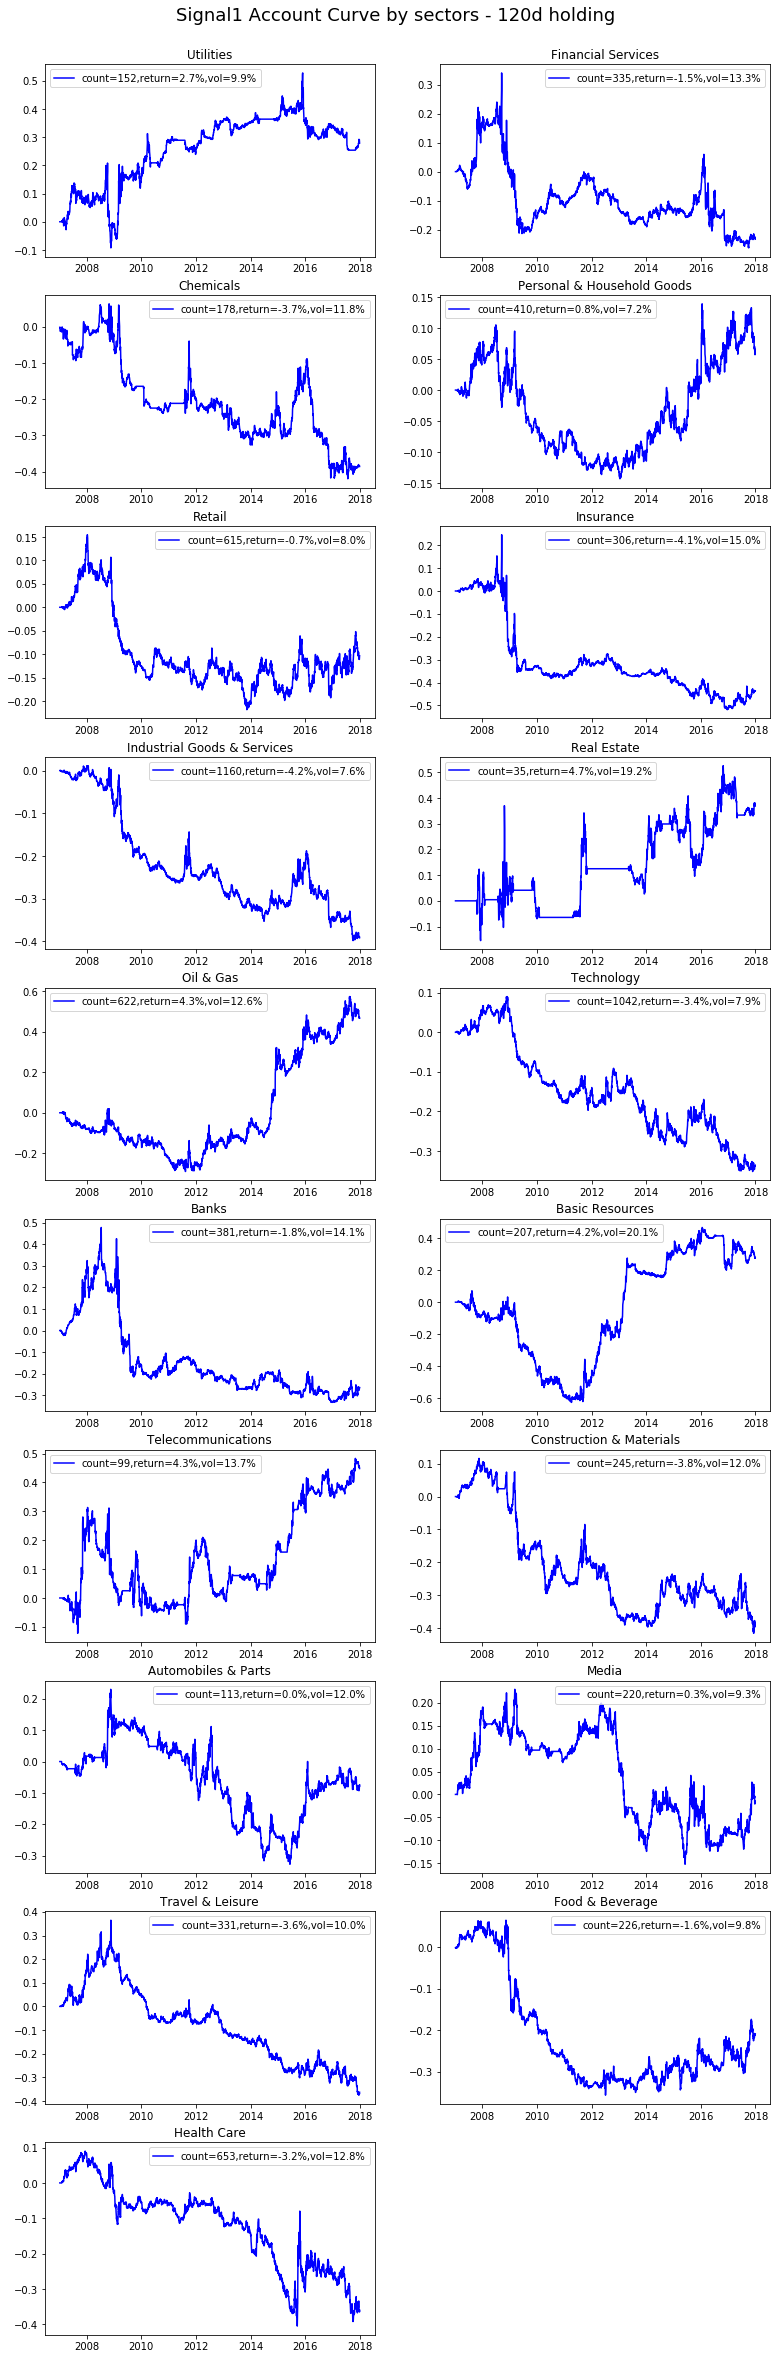

In [283]:
plot_account_curve_by_sector(data_dict_US["Property"]["Sector"],(13,80),18,
                            "Signal1 Account Curve by sectors - 120d holding",-signal1_rel_df_date_short_US,
                            50,5,data_dict_US["Volume"],data_dict_US["Date"],0.1)

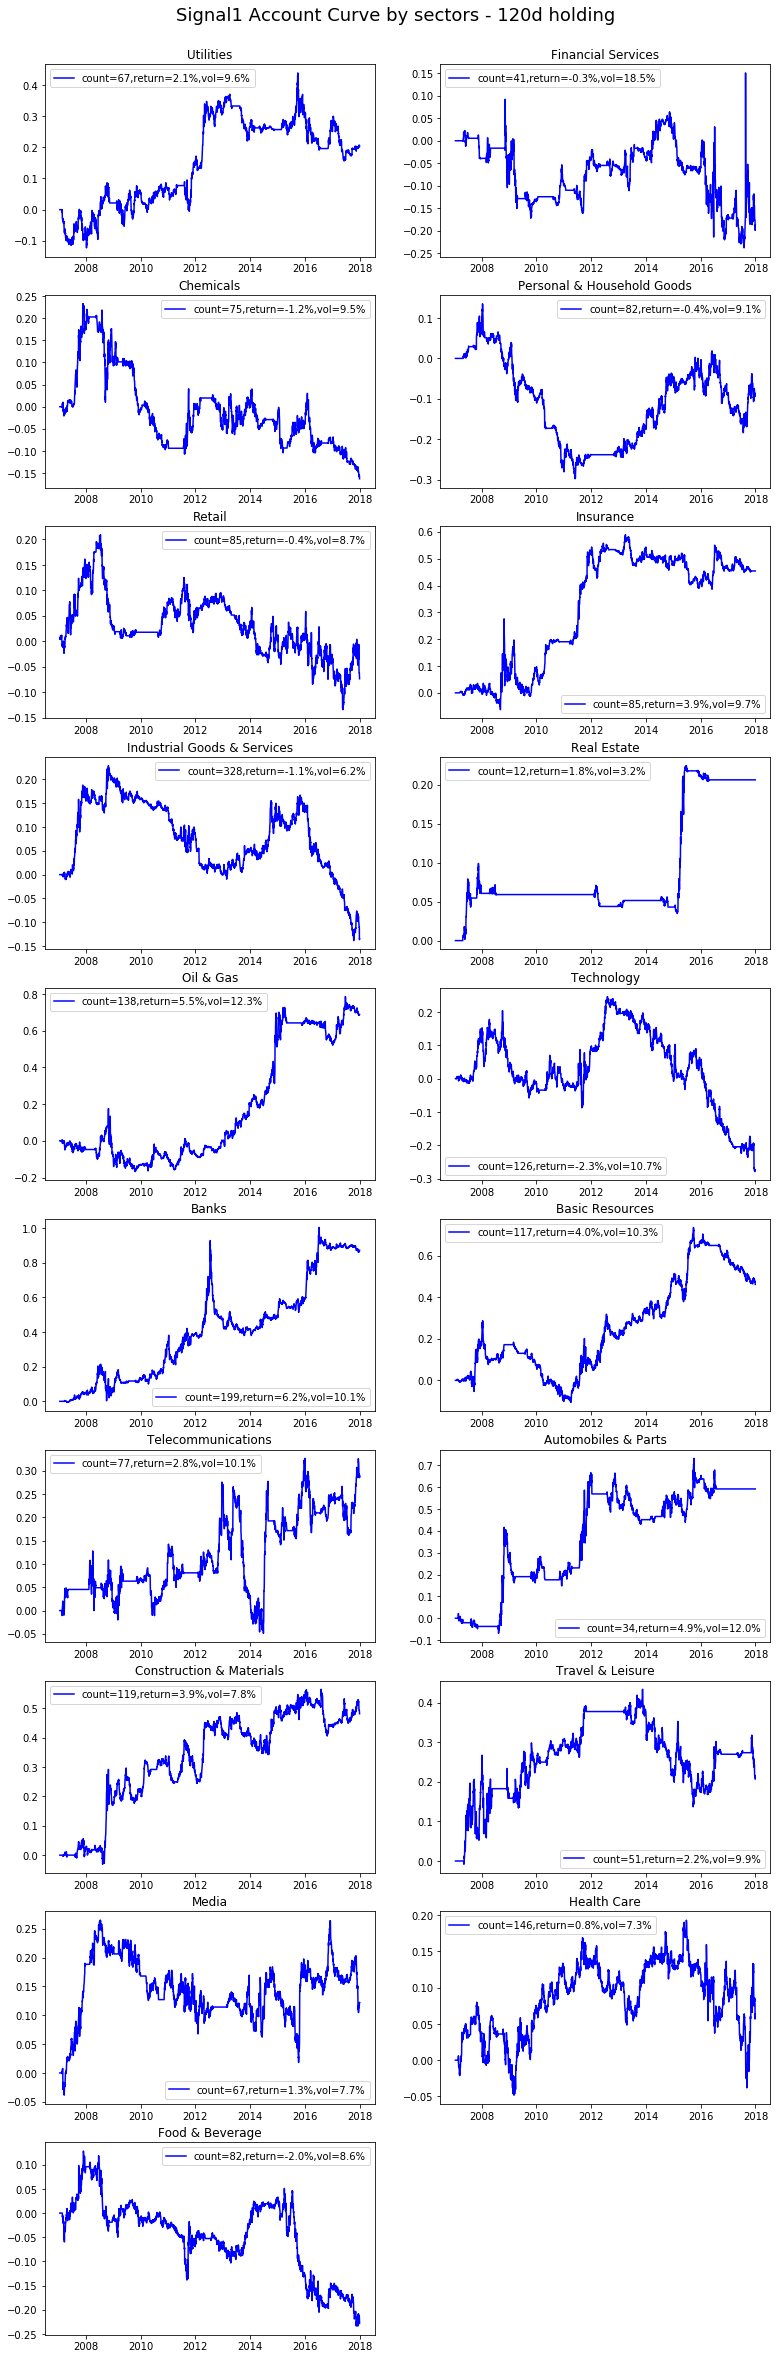

In [324]:
plot_account_curve_by_sector(data_dict_Europe["Property"]["Sector"],(13,80),18,
                            "Signal1 Account Curve by sectors - 120d holding",-signal1_rel_df_date_short_Europe,
                            50,5,data_dict_Europe["Volume"],data_dict_Europe["Date"],0.1)

### 7.7 - Short signal performance with stop loss

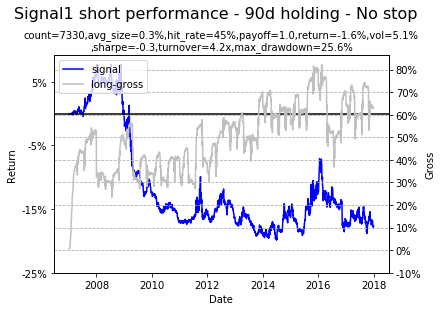

In [307]:
plot_account_curve(signal1_account(-signal1_rel_df_date_short_US,50,100,data_dict_US["Volume"],data_dict_US["Date"],0.1),
                   "Date","Signal1 short performance - 90d holding - No stop",[6,4])

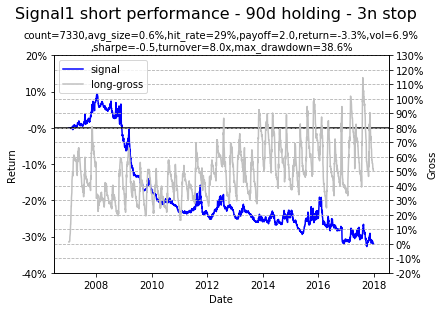

In [308]:
plot_account_curve(signal1_account(signal1_filter_stop(-signal1_rel_df_date_short_US,3,rel_return_US,30)
                                   ,50,100,data_dict_US["Volume"],data_dict_US["Date"],0.1),
                   "Date","Signal1 short performance - 90d holding - 3n stop",[6,4])

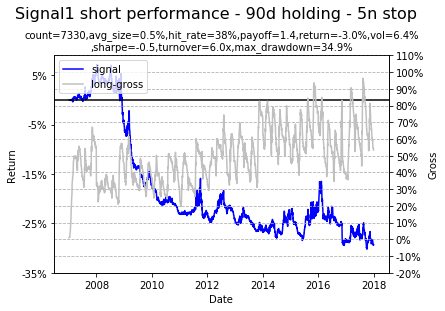

In [309]:
plot_account_curve(signal1_account(signal1_filter_stop(-signal1_rel_df_date_short_US,5,rel_return_US,30)
                                   ,50,100,data_dict_US["Volume"],data_dict_US["Date"],0.1),
                   "Date","Signal1 short performance - 90d holding - 5n stop",[6,4])

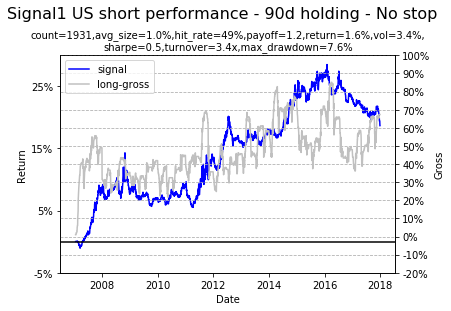

In [341]:
plot_account_curve(signal1_account(-signal1_rel_df_date_short_Europe,50,100,data_dict_Europe["Volume"],data_dict_Europe["Date"],0.1),
                   "Date","Signal1 US short performance - 90d holding - No stop",[6,4])

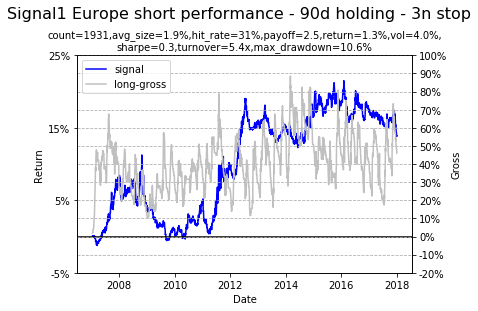

In [327]:
plot_account_curve(signal1_account(signal1_filter_stop(-signal1_rel_df_date_short_Europe,3,rel_return_Europe,30)
                                   ,50,100,data_dict_Europe["Volume"],data_dict_Europe["Date"],0.1),
                   "Date","Signal1 Europe short performance - 90d holding - 3n stop",[6,4])

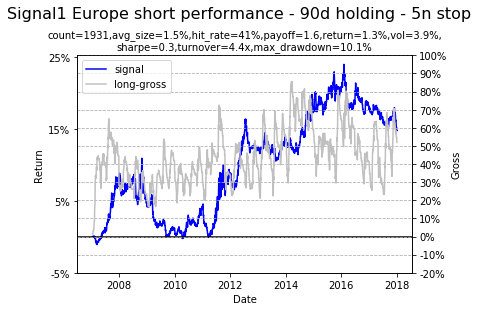

In [328]:
plot_account_curve(signal1_account(signal1_filter_stop(-signal1_rel_df_date_short_Europe,5,rel_return_Europe,30)
                                   ,50,100,data_dict_Europe["Volume"],data_dict_Europe["Date"],0.1),
                   "Date","Signal1 Europe short performance - 90d holding - 5n stop",[6,4])

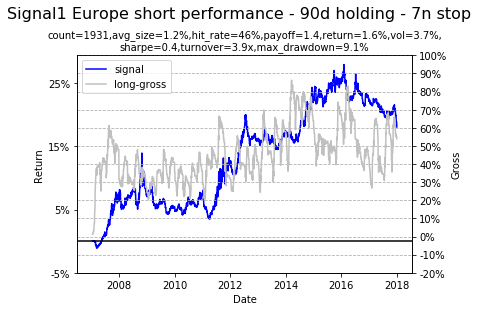

In [329]:
plot_account_curve(signal1_account(signal1_filter_stop(-signal1_rel_df_date_short_Europe,7,rel_return_Europe,30)
                                   ,50,100,data_dict_Europe["Volume"],data_dict_Europe["Date"],0.1),
                   "Date","Signal1 Europe short performance - 90d holding - 7n stop",[6,4])

### 7.8 - Performance for the following quarters - short version

In [631]:
signal1_short_follow_US=signal1_follow(signal1_short_US,data_dict_US["Date"],10)
signal1_short_follow=signal1_follow(signal1_short_Europe,data_dict_Europe["Date"],10)

In [632]:
follow_short_US=signal1_follow_EAR(signal1_short_follow_US,abs_return_US,2,30)
follow_short_Europe=signal1_follow_EAR(signal1_short_follow,abs_return_Europe,2,30)

In [633]:
follow_short_US=follow_short_US.sort_values(by='Quarter+0',axis=1)
follow_short_Europe=follow_short_Europe.sort_values(by='Quarter+0',axis=1)

## 8 - Logistic regression project 

In [655]:
EAR_test=EAR_df(data_dict_US["Date"],rel_return_US,2,30)

In [656]:
EAR_test

Unnamed: 1 Unnamed: 2 Unnamed: 3 Unnamed: 4 Unnamed: 5 Unnamed: 6  \
1570117D US       None       None       None       None       None       None   
A US           1.34707    5.94879    6.21179    1.21307   0.967882   -4.98674   
AA US         -1.68631   0.129174    6.89698  -0.288539   -11.4862        NaN   
AAL US         -4.3282    0.79338   -5.85364    -6.5419  -0.809899   0.694176   
AAN US        -5.33574    12.0154    13.1536   -3.86033    4.67915     6.5112   
AAON US      -0.149064    3.55661   -2.18701   0.530432   -2.20383   0.387135   
AAP US         7.19054   -6.02277     -4.701   -1.61486    10.1749   -6.09498   
AAPL US         2.6186    7.61029   0.578429    12.4599  -0.996988    8.75428   
AAWW US       -3.96025    6.49403   -5.95168    3.18517    4.08138    -8.1403   
AAXN US       -4.49917   -10.7897    3.19132   -6.20801    5.79071    0.68234   
ABAX US        5.70244    -6.7607   -9.27957    1.28504   -10.2497   -10.8185   
ABBV US       0.650174   -2.75892    2.93383  -0.621884   -10.7024    3.75207   
ABC US        -1.54449   -10.6078    3.14244    3.42517    2.12585    8.68652   
ABCB US        -2.1077  0.0212823    1.69479    1.36738  -0.390486    6.88526   
ABG US         3.91539   -2.78186   -1.61835    1.96348   -3.29974  -0.589114   
ABM US        -12.5024   -17.8369      3.193    6.23473   -5.82079    6.78763   
ABMD US        3.62452    1.11649    1.52408   -3.31852   -2.47374    1.20689   
ABT US         1.61986    4.04121    1.21716    1.15776   -1.03162    3.10863   
ACAD US       -4.36968    4.08153   -4.19925    -4.0811    6.42941   -1.06878   
ACGL US       -1.49908   -8.38457      2.764   -1.42114   -0.47627     5.4388   
ACHC US       -14.5248    4.33677   -2.08867    4.43139     1.7881  -0.322653   
ACIA US       -8.10039   0.564205   -1.73822    -3.4421  -0.573506    9.23844   
ACIW US       -1.36511   -2.73416    9.57794    10.5463    -2.9459   0.414234   
ACM US        -6.68097    5.96559   0.225958   -0.17697    6.73448   -1.31847   
ACN US         2.18462   -2.36986    -7.9544   -9.60849   -4.41611    6.36172   
ACOR US        1.24869   -1.57326  -0.377083   0.766437        NaN        NaN   
ACXM US        12.2285   -9.54764   -6.46005    11.1889    12.2812    7.66539   
ADBE US     -0.0505733   -6.73783    4.14342     10.239   -2.04925     11.307   
ADI US        -6.80306    4.53654   -3.21281    4.43636    4.38296   -1.62732   
ADM US        -8.07933   0.642837   -13.2661   -1.40094    13.3052  -0.337777   
...                ...        ...        ...        ...        ...        ...   
SRX US             NaN        NaN        NaN        NaN        NaN        NaN   
SRZ US             NaN        NaN        NaN        NaN        NaN        NaN   
SSCCQ US           NaN        NaN        NaN        NaN        NaN        NaN   
SSW US             NaN        NaN        NaN        NaN        NaN        NaN   
STU US             NaN        NaN        NaN        NaN        NaN        NaN   
SVNTQ US           NaN        NaN        NaN        NaN        NaN        NaN   
SWIM US            NaN        NaN        NaN        NaN        NaN        NaN   
THMRQ US           NaN        NaN        NaN          0   -4.65717    7.35705   
THQIQ US           NaN        NaN        NaN        NaN        NaN        NaN   
TNP US             NaN        NaN        NaN        NaN        NaN        NaN   
TSFG US            NaN        NaN        NaN        NaN        NaN        NaN   
TT US              NaN          0     2.9174   -5.41071    6.79589    9.29416   
TTEC US            NaN        NaN        NaN        NaN        NaN        NaN   
TTI US             NaN        NaN        NaN        NaN        NaN        NaN   
UAPH US            NaN  -0.415283   -0.12237  -0.833527    2.08163   -8.33056   
UB US              NaN        NaN        NaN        NaN        NaN        NaN   
UCBHQ US           NaN        NaN        NaN        NaN        NaN          0   
UEPS US            NaN        NaN        Na

In [657]:
data_dict_US["Date"]

Unnamed: 1 Unnamed: 2 Unnamed: 3 Unnamed: 4 Unnamed: 5 Unnamed: 6  \
Unnamed: 0                                                                      
1570117D US        NaT        NaT        NaT        NaT        NaT        NaT   
A US        2017-11-20 2017-08-15 2017-05-22 2017-02-14 2016-11-15 2016-08-17   
AA US       2017-10-18 2017-07-19 2017-04-24 2017-01-24 2016-10-11        NaT   
AAL US      2017-10-26 2017-07-28 2017-04-27 2017-01-27 2016-10-20 2016-07-22   
AAN US      2017-10-27 2017-07-28 2017-04-28 2017-02-17 2016-10-28 2016-07-29   
AAON US     2017-11-02 2017-08-03 2017-05-04 2017-02-23 2016-11-03 2016-08-04   
AAP US      2017-11-14 2017-08-15 2017-05-24 2017-02-21 2016-11-14 2016-08-16   
AAPL US     2017-11-02 2017-08-01 2017-05-02 2017-01-31 2016-10-25 2016-07-26   
AAWW US     2017-11-07 2017-08-02 2017-05-03 2017-02-23 2016-11-03 2016-08-03   
AAXN US     2017-11-07 2017-08-08 2017-05-09 2017-02-28 2016-11-09 2016-08-04   
ABAX US     2017-10-24 2017-07-27 2017-04-27 2017-01-26 2016-10-25 2016-07-21   
ABBV US     2017-10-27 2017-07-28 2017-04-27 2017-01-27 2016-10-28 2016-07-29   
ABC US      2017-11-02 2017-08-03 2017-05-04 2017-01-31 2016-11-02 2016-08-02   
ABCB US     2017-10-19 2017-07-21 2017-04-21 2017-01-20 2016-10-17 2016-07-22   
ABG US      2017-10-24 2017-07-25 2017-04-27 2017-02-07 2016-10-25 2016-07-26   
ABM US      2017-12-13 2017-09-06 2017-06-07 2017-03-07 2016-12-13 2016-09-07   
ABMD US     2017-10-26 2017-07-27 2017-05-04 2017-01-26 2016-10-27 2016-07-28   
ABT US      2017-10-18 2017-07-20 2017-04-19 2017-01-25 2016-10-19 2016-07-20   
ACAD US     2017-11-07 2017-08-08 2017-05-09 2017-02-28 2016-11-07 2016-08-04   
ACGL US     2017-10-25 2017-07-26 2017-04-25 2017-02-13 2016-10-26 2016-07-27   
ACHC US     2017-10-24 2017-07-27 2017-04-25 2017-02-23 2016-11-01 2016-07-29   
ACIA US     2017-11-02 2017-08-03 2017-05-09 2017-02-23 2016-11-10 2016-08-11   
ACIW US     2017-11-02 2017-07-27 2017-05-04 2017-03-01 2016-11-03 2016-07-28   
ACM US      2017-11-13 2017-08-08 2017-05-09 2017-02-07 2016-11-14 2016-08-09   
ACN US      2017-12-21 2017-09-28 2017-06-22 2017-03-23 2016-12-21 2016-09-29   
ACOR US     2017-10-31 2017-07-27 2017-04-27 2017-02-14 2016-10-27 2016-07-28   
ACXM US     2017-11-01 2017-08-03 2017-05-16 2017-01-31 2016-11-07 2016-08-04   
ADBE US     2017-12-14 2017-09-19 2017-06-20 2017-03-16 2016-12-15 2016-09-20   
ADI US      2017-11-21 2017-08-30 2017-05-31 2017-02-15 2016-11-22 2016-08-17   
ADM US      2017-10-31 2017-08-01 2017-05-02 2017-02-07 2016-11-01 2016-08-02   
...                ...        ...        ...        ...        ...        ...   
NaN                NaT        NaT        NaT        NaT        NaT        NaT   
NaN                NaT        NaT        NaT        NaT        NaT        NaT   
NaN                NaT        NaT        NaT        NaT        NaT        NaT   
NaN                NaT        NaT        NaT        NaT        NaT        NaT   
NaN                NaT        NaT        NaT        NaT        NaT        NaT   
NaN                NaT        NaT        NaT        NaT        NaT        NaT   
NaN                NaT        NaT        NaT        NaT        NaT        NaT   
NaN                NaT        NaT        NaT        NaT        NaT        NaT   
NaN                NaT        NaT        NaT        NaT        NaT        NaT   
NaN                NaT        NaT        NaT        NaT        NaT        NaT   
NaN                NaT        NaT        NaT        NaT        NaT        NaT   
NaN                NaT        NaT        NaT        NaT        NaT        NaT   
NaN                NaT        NaT        NaT        NaT        NaT        NaT   
NaN                NaT        NaT        NaT        NaT        NaT        NaT   
NaN                NaT        NaT        NaT        NaT        NaT        NaT   
NaN                NaT        NaT        NaT        NaT        NaT        NaT   
NaN                NaT        NaT        Na

In [588]:
EAR_test.stack(level=0).values.reshape(-1,1).shape

(63242, 1)

In [589]:
data_dict_US["Revision"].stack(level=0).values.reshape(-1,1).shape

(57951, 1)

In [593]:
data_dict_US["Revision"].stack(level=0).shape

(57951,)

In [592]:
data_dict_US["Date"].stack(level=0).shape

(89246,)

In [602]:
my_list=[]
for ticker,row in data_dict_US["Date"].iterrows():
    for date in row:
        if type(date)==pd._libs.tslib.NaTType:
            pass
        else:
            my_list.append((ticker,date.strftime("%d/%b/%Y")))
        

In [617]:
test_frame=pd.DataFrame(my_list).set_index(0)
test_frame.columns=["Date"]
test_frame.index.name="Ticker"
test_frame

Date
Ticker              
A US     20/Nov/2017
A US     15/Aug/2017
A US     22/May/2017
A US     14/Feb/2017
A US     15/Nov/2016
A US     17/Aug/2016
A US     16/May/2016
A US     16/Feb/2016
A US     16/Nov/2015
A US     17/Aug/2015
A US     18/May/2015
A US     17/Feb/2015
A US     17/Nov/2014
A US     14/Aug/2014
A US     14/May/2014
A US     13/Feb/2014
A US     14/Nov/2013
A US     14/Aug/2013
A US     14/May/2013
A US     14/Feb/2013
A US     19/Nov/2012
A US     15/Aug/2012
A US     14/May/2012
A US     15/Feb/2012
A US     15/Nov/2011
A US     15/Aug/2011
A US     13/May/2011
A US     14/Feb/2011
A US     12/Nov/2010
A US     16/Aug/2010
...              ...
ZOLT US  09/Feb/2009
ZOLT US  01/Dec/2008
ZOLT US  11/Aug/2008
ZOLT US  12/May/2008
ZOLT US  11/Feb/2008
ZOLT US  28/Nov/2007
ZOLT US  06/Aug/2007
ZOLT US  03/May/2007
ZOLT US  09/Feb/2007
ZRAN US  26/Jul/2011
ZRAN US  09/May/2011
ZRAN US  03/Feb/2011
ZRAN US  25/Oct/2010
ZRAN US  26/Jul/2010
ZRAN US  26/Apr/2010
ZRAN US  25/Jan/2010
ZRAN US  26/Oct/2009
ZRAN US  27/Jul/2009
ZRAN US  28/Apr/2009
ZRAN US  26/Jan/2009
ZRAN US  27/Oct/2008
ZRAN US  28/Jul/2008
ZRAN US  21/Apr/2008
ZRAN US  28/Jan/2008
ZRAN US  22/Oct/2007
ZRAN US  23/Jul/2007
ZRAN US  24/Apr/2007
ZRAN US  20/Apr/2007
ZRAN US  20/Apr/2007
ZRAN US  20/Apr/2007

[89246 rows x 1 columns]

In [654]:
test_frame[:5].apply(lambda x:EAR_calc(x["Date"],x.name,rel_return_US,2,30),axis=1)

Ticker
A US    1.347068
A US    5.948789
A US    6.211794
A US    1.213069
A US    0.967882
dtype: float64

In [643]:
test_frame[:5].iloc[1]

Date    15/Aug/2017
Name: A US, dtype: object

In [647]:
EAR_calc??

In [600]:
type(data_dict_US["Date"].iloc[0,0])

pandas._libs.tslib.NaTType